# Final Team Project - SliceWise: Pricing, Menu, and Ratings Analytics for U.S. Pizza Restaurants

### Team 9: Duy-Anh Dang, Arjun Venkatesh, and Nancy Walker

Course: ADS 505 Applied Data Science for Business

Instructor: Jules Malin

## Introduction

The Datafiniti dataset provides information on pizza restaurants in the United States. Information in this dataset includes restaurant names, locations, menu items, and prices. The goal of this analysis is to connect menu item type, pricing, and regional context to provide insights and recommendations on pricing strategies for pizza restaurant operators. Competitive pricing strategies can help pizza restaurants maximize revenue and attract more customers.

## Problem Statement

Predicting pizza prices by location, restaurant type, and menu items so companies can implement competitive pricing strategies.

## Exploratory Data Analysis

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder # preprocessing for numerical and categorical data
from sklearn.compose import ColumnTransformer # to apply different preprocessing to different columns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV # hyperparameter tuning
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import KFold
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV


from imblearn.over_sampling import SMOTENC # imblearn for handling class imbalance
from imblearn.pipeline import Pipeline # imblearn pipeline to handle resampling within cross-validation

from dateutil import parser # for parsing date strings

import kagglehub # to access Kaggle datasets
import os # to manage file paths

In [2]:
# Helpers

def ensure_dir(p: str) -> str:
    os.makedirs(p, exist_ok=True)
    return p

def coerce_numeric(df: pd.DataFrame, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

def parse_dates(df: pd.DataFrame, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

def top_counts(s: pd.Series, n=20):
    return (
        s.dropna()
         .astype(str).str.strip()
         .replace("", np.nan).dropna()
         .value_counts()
         .head(n)
    )

In [3]:
# Download latest version
path = kagglehub.dataset_download("datafiniti/pizza-restaurants-and-the-pizza-they-sell")

print("Path to dataset files:", path)

Path to dataset files: /Users/user/.cache/kagglehub/datasets/datafiniti/pizza-restaurants-and-the-pizza-they-sell/versions/2


In [4]:
#Files downloaded
files = os.listdir(path)
print("Files downloaded:", files)

Files downloaded: ['8358_1.csv', 'Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_May19.csv']


In [5]:
# Select the first CSV file (assuming it exists)
csv_files = [f for f in files if f.endswith(".csv")] # Get all CSV file
print("CSV files found:", csv_files)

CSV files found: ['8358_1.csv', 'Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_May19.csv']


In [6]:
# Load the first CSV file found
# data1 = pd.read_csv(os.path.join(path, csv_files[0]))
# Have not used this dataset for analysis

# Load the second dataset
if len(csv_files) > 1:
    data2 = pd.read_csv(os.path.join(path, csv_files[1]))


In [7]:
# print the first few rows of the first dataset
# print(data1.head())
# Have not used this dataset for analysis

In [8]:
# print the first few rows of the second dataset
print(data2.head())

                     id             dateAdded           dateUpdated  \
0  AVz3Y-7h3D1zeR_xDAqm  2017-06-30T05:05:40Z  2019-05-01T15:43:09Z   
1  AVweGPFF_7pvs4fzAAzQ  2016-04-02T04:02:49Z  2019-05-01T15:27:50Z   
2  AVwdRGa9_7pvs4fz4E3K  2016-03-03T18:39:49Z  2019-05-01T12:52:25Z   
3  AVwdX4psIN2L1WUfvJB1  2016-03-29T05:08:59Z  2019-05-01T12:52:20Z   
4  AVwdaeTtkufWRAb55pSH  2016-03-31T02:34:04Z  2019-05-01T12:50:45Z   

             address                                         categories  \
0   4203 E Kiehl Ave  Pizza,Restaurant,American restaurants,Pizza Pl...   
1  25 E Camelback Rd                      Pizza,Pizza Place,Restaurants   
2    3703 Paxton Ave                 Restaurant,Pizza Place,Restaurants   
3    30495 John R Rd       Pizza,Carry-out food,Pizza Place,Restaurants   
4   3600 Eastern Ave  Pizza,American restaurants,Pizza Place,Pizza e...   

               primaryCategories             city country  \
0  Accommodation & Food Services         Sherwood      US   


Two possible datasets can be used for this project.

data1 is a list of over 3,500 pizzas from multiple restaurants.
- curated dataset of pizza-only restaurants in Datafiniti's business database.
- Useful for pizza-specific analyses.

Data2 is a list of 10,000 pizza restaurants in Datafiniti's business database, spanning **from January 2018 to May 2019**.
- a larger, broader subset of Datafiniti's business database.
- useful to analyze pizza restaurants in comparison to other types of restaurants.

In [9]:
# data1.info() # Have not used this dataset for analysis
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  10000 non-null  object 
 1   dateAdded           10000 non-null  object 
 2   dateUpdated         10000 non-null  object 
 3   address             10000 non-null  object 
 4   categories          10000 non-null  object 
 5   primaryCategories   10000 non-null  object 
 6   city                10000 non-null  object 
 7   country             10000 non-null  object 
 8   keys                10000 non-null  object 
 9   latitude            10000 non-null  float64
 10  longitude           10000 non-null  float64
 11  menuPageURL         1679 non-null   object 
 12  menus.amountMax     10000 non-null  float64
 13  menus.amountMin     10000 non-null  float64
 14  menus.currency      10000 non-null  object 
 15  menus.dateSeen      10000 non-null  object 
 16  menus

Two possible datasets.

Dataset 1: 8358_1.csv
- This dataset contains information on pizza restaurants and the types of Pizza they sell.
- It has 3,519 rows and 21 columns.
- There are a few features with missing values.

Dataset 2: Datafiniti_Pizza_Restaurants_and_the_Pizza_They_Sell_May19.csv
- list of 10,000 restaurants in Datafiniti's business database between January 2018 and May 2019
- There are 24 feature columns
- Business listings include a variation of the phrase Pizza within the categories and menu.name variables
- fields have been flattened to make it easier to work with
- This dataset is a sample of a larger dataset that is available through Datafiniti's business database.


## Data2 Datafiniti Pizza Restaurants and the Pizza They Sell (May19)

In [10]:
# Data distribution
data2.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,10000.0,38.371895,4.573537,21.421326,34.422946,40.118880,40.905048,64.85050
longitude,10000.0,-90.063800,17.340379,-157.802443,-104.801126,-82.909949,-75.194741,-71.94617
menus.amountMax,10000.0,14.032670,17.607233,0.000000,8.490000,13.390000,17.950000,1395.00000
menus.amountMin,10000.0,13.416902,10.742678,0.000000,8.000000,12.990000,16.990000,243.00000
priceRangeMin,10000.0,4.655500,9.828412,0.000000,0.000000,0.000000,0.000000,50.00000
priceRangeMax,10000.0,27.764200,6.017526,7.000000,25.000000,25.000000,25.000000,55.00000


In [11]:
# Check for missing values
data2.isnull().sum()

id                       0
dateAdded                0
dateUpdated              0
address                  0
categories               0
primaryCategories        0
city                     0
country                  0
keys                     0
latitude                 0
longitude                0
menuPageURL           8321
menus.amountMax          0
menus.amountMin          0
menus.currency           0
menus.dateSeen           0
menus.description     6282
menus.name               0
name                     0
postalCode               4
priceRangeCurrency       0
priceRangeMin            0
priceRangeMax            0
province                 0
dtype: int64

There are a few features with missing values.

**Data2 Missing Values and Proposed Treatments:**

There are tree features with missing values in dataset 2.

- menuPageURL - 8,321 missing values ( Identifier/Link to the menu page on the business's website), leave as null and drop column
- menus.description - 6,282 missing values ( Description of the menu item)
    - Options: drop column, impute with placeholder string (for NLP), or transform to binary variable
- postalCode - 4 missing values ( Postal code of the business), impute with mode


*Data1 Missing Values and Proposed Treatments: (for reference only, have not used this dataset for analysis)*

- *menuPageURL - 2,900 missing values ( Identifier/Link to the menu page on the business's website), leave as null and drop column*
- *menu.amountMax - 562 missing values ( Maximum price of the menu item), impute with median*
- *menus.amountMin - 562 missing values ( Minimum price of the menu item), impute with median*
- *menus.currency - 559 missing values ( Currency of the menu item price), impute with mode*
- *menus.description - 1984 missing values ( Description of the menu item)*
    - *Options: drop column, impute with placeholder string (for NLP), or transform to binary variable*
- *postalCode - 26 missing values ( Postal code of the business), impute with mode*
- *priceRangeCurrency - 1953 missing values ( Currency of the price range), impute with mode*
- *priceRangeMin - 1953 missing values ( Minimum price of the price range), impute with median*
- *priceRangeMax - 1953 missing values ( Maximum price of the price range), impute with median*


In [12]:
# Remove identifier columns for modeling
data2_cleaned = data2.drop(columns=['id', 'categories', 'address', 'keys', 'menuPageURL']).copy()

# Impute missing values for numeric columns with the mean
# num_cols = data2_cleaned.select_dtypes(include=['float64', 'int64']).columns
# data2_cleaned[num_cols] = data2_cleaned[num_cols].fillna(data2_cleaned[num_cols].mean())
# Above code commented out because there are no missing valuse in numeric columns in dataset 2

# Impute missing values for categorical columns (postalCode is the only categorical variable in dataset 2 that needs impute)
# Impute with the mode
cat_cols = ['postalCode']
for col in cat_cols:
    mode_value = data2_cleaned[col].mode()[0]
    data2_cleaned[col] = data2_cleaned[col].fillna(mode_value)

# Create binary feature for menus.description and drop original column
data2_cleaned['has_description'] = np.where(data2_cleaned['menus.description'].notnull(), 1, 0)
data2_cleaned = data2_cleaned.drop(columns=['menus.description'])

# Verify no missing values remain
data2_cleaned.isnull().sum()

dateAdded             0
dateUpdated           0
primaryCategories     0
city                  0
country               0
latitude              0
longitude             0
menus.amountMax       0
menus.amountMin       0
menus.currency        0
menus.dateSeen        0
menus.name            0
name                  0
postalCode            0
priceRangeCurrency    0
priceRangeMin         0
priceRangeMax         0
province              0
has_description       0
dtype: int64

All missing values in dataset 2 have been treated.

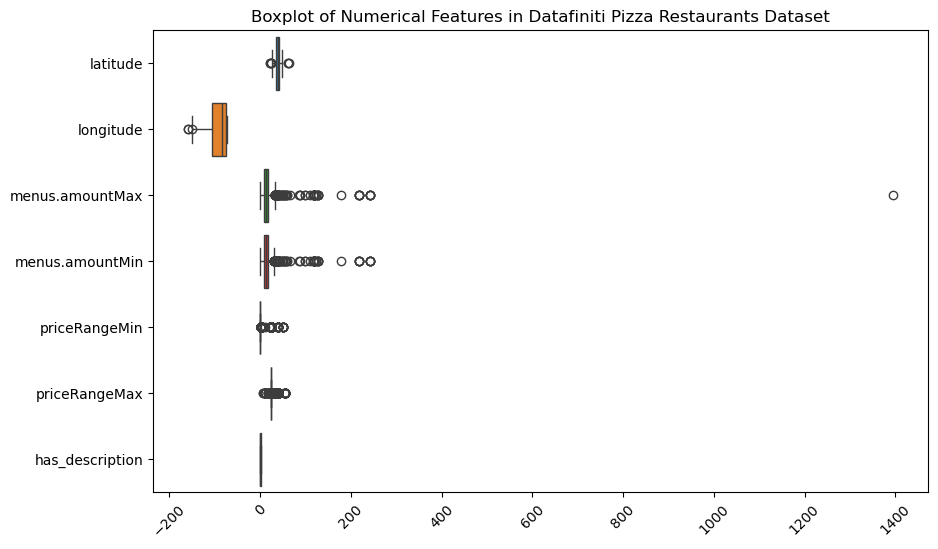

In [13]:
# Select numerical columns in Dataset 2
num_columns = data2_cleaned.select_dtypes(include=['float64','int64']).columns

# Boxplot for numerical features in Dataset 2
plt.figure(figsize=(10,6))
sns.boxplot(data=data2_cleaned[num_columns], orient='h')
plt.title('Boxplot of Numerical Features in Datafiniti Pizza Restaurants Dataset')
plt.xticks(rotation=45)
plt.show()


Menus.amountMax has an extreme outlier of a pizza that cost $1,395. This extreme value may be due to a data entry error or an expensive restaurant selling a luxury pizza. The outlier can be removed for analysis.

In [14]:
# remove the outlier in menus.amountMax
data2_cleaned = data2_cleaned[data2_cleaned['menus.amountMax']<500]


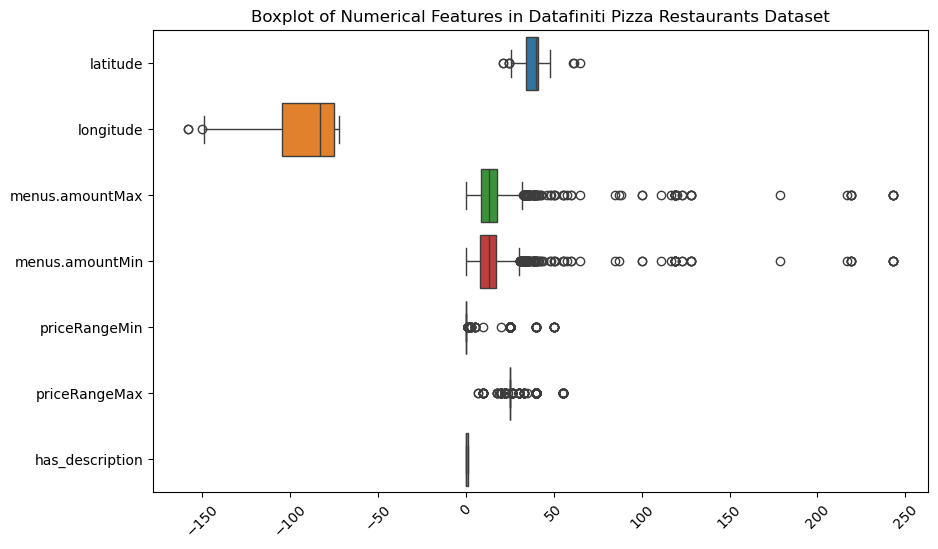

In [15]:
# Recheck data distribution after removig outlier
# Boxplot for numerical features in Dataset 2
plt.figure(figsize=(10,6))
sns.boxplot(data=data2_cleaned[num_columns], orient='h')
plt.title('Boxplot of Numerical Features in Datafiniti Pizza Restaurants Dataset')
plt.xticks(rotation=45)
plt.show()

A clear distribution of numerical features becomes visible once the extreme outlier is removed.

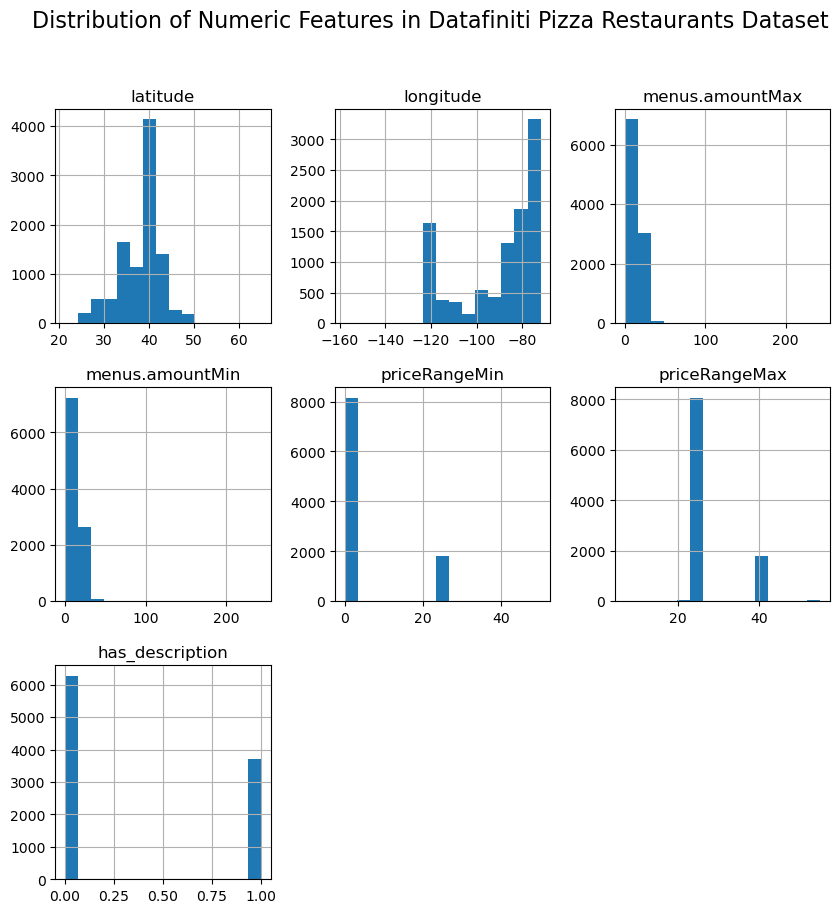

In [16]:
# Feature distribution of numeric features in Dataset 2
data2_cleaned[num_columns].hist(figsize=(10,10),bins=15)
plt.suptitle("Distribution of Numeric Features in Datafiniti Pizza Restaurants Dataset", fontsize =16)
plt.show()

The histogram also provides a clear visualization of the distribution of the numeric feature.

Longitude and latitude are continuous variables and display pizza location information.

- Options: keep as is, view mapping, compute distance reference point, group into regions, or use postal code/ city/ province/state to group instead of raw coordinates.

menus.amount Max and Min are continuous variables that display the price range of menu items. These variables are skewed right. (may need normalization/transformation for modeling)

priceRange Min and Max look as though they are categorical variables with numeric values. Likely displaying similar information to menus.amount Max and Min.

has_description is a binary variable that indicates whether the menu item has a description. This variable was created from the menus.description variable, which had many missing values.

<Axes: >

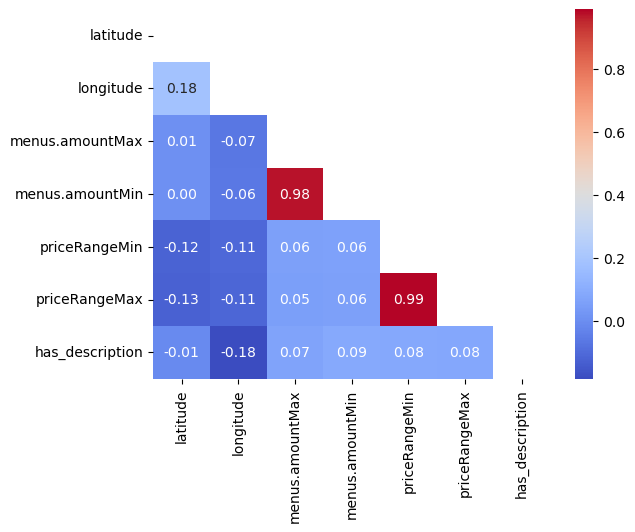

In [17]:
# Plot heatmap to visualize correlations
plt.figuresize=(10,8)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[num_columns].corr()))

sns.heatmap(data2_cleaned[num_columns].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)

Menus.amountMin and menus.amountMax are highly correlated (r = 0.98).
- Combine the average of these variables for a more flexible option of modeling pricing.

priceRangeMin and priceRangeMax are also highly correlated (r = 0.99).
- Combine the average of these variables for a more flexible option of modeling pricing.

All other numeric features have low correlation and can be kept as is for modeling.

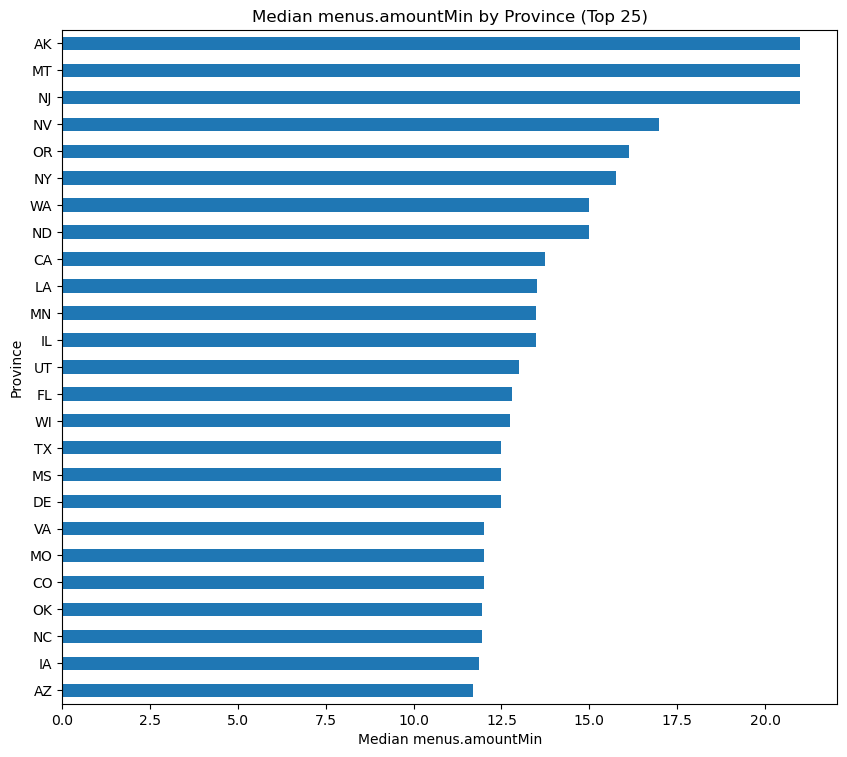

In [18]:
def plot_price_by_province(df: pd.DataFrame, outdir: str, tag: str):
    base = [c for c in ["menus.amountMin", "priceRangeMin"] if c in df.columns]
    if not base or "province" not in df.columns:
        return
    c = base[0]
    tmp = df.copy()
    tmp[c] = pd.to_numeric(tmp[c], errors="coerce")
    gp = tmp.groupby("province")[c].median().dropna().sort_values(ascending=False).head(25)
    if gp.empty:
        return
    plt.figure(figsize=(10, max(4, 0.35*len(gp))))
    gp.iloc[::-1].plot(kind="barh")
    plt.title(f"Median {c} by Province (Top 25)")
    plt.xlabel(f"Median {c}")
    plt.ylabel("Province")

plot_price_by_province(data2_cleaned, outdir=".", tag="data2_cleaned")
plt.show()

Chart displays the median price of menu items by province. AK, MT, and Nj have the highest median prices for menu items at around $20. AZ and IA have the lowest median prices for menu items at around $12.

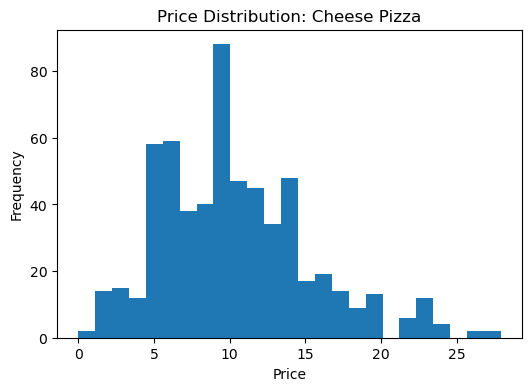

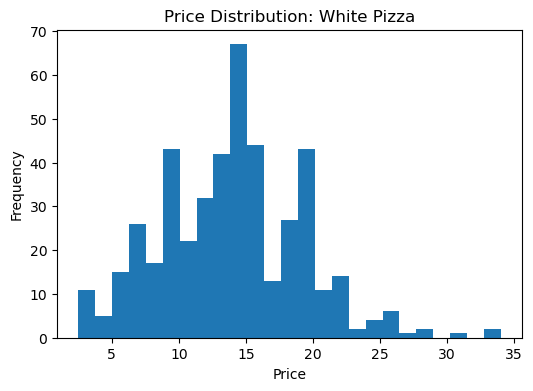

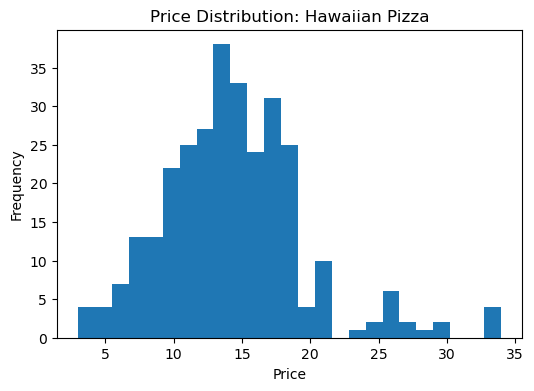

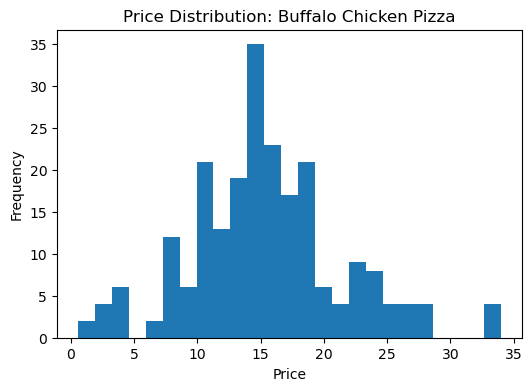

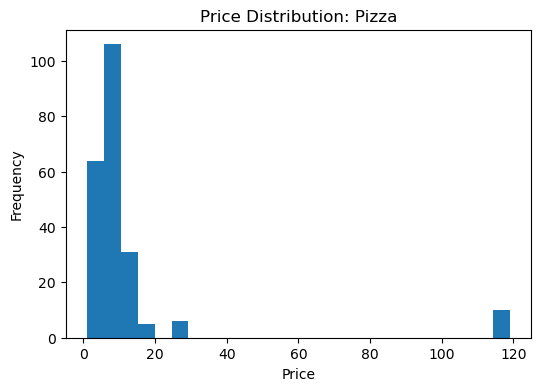

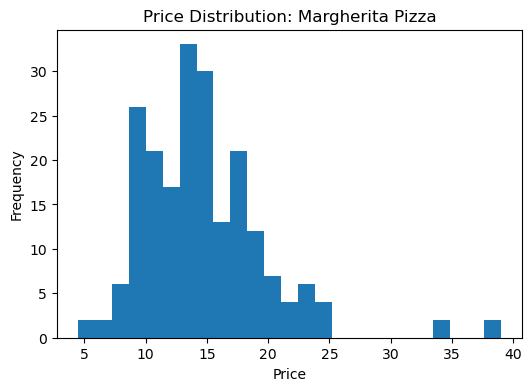

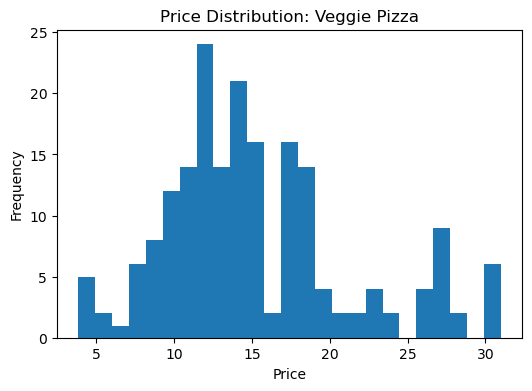

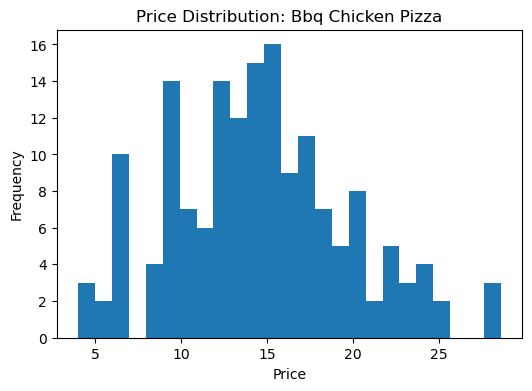

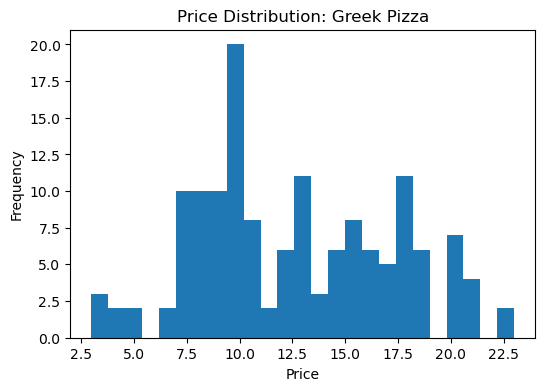

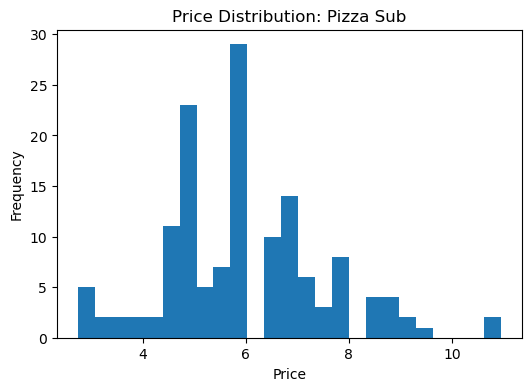

In [19]:
def plot_item_prices(df: pd.DataFrame, outdir: str, tag: str):
    if "menus.name" not in df.columns:
        return
    d = df.copy()
    for c in ["menus.amountMin", "menus.amountMax"]:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors="coerce")
    top_items = d["menus.name"].dropna().astype(str).value_counts().head(10).index.tolist()
    for item in top_items:
        sub = d[d["menus.name"].astype(str) == item]
        vals = []
        if "menus.amountMin" in sub.columns:
            vals.append(pd.to_numeric(sub["menus.amountMin"], errors="coerce"))
        if "menus.amountMax" in sub.columns:
            vals.append(pd.to_numeric(sub["menus.amountMax"], errors="coerce"))
        if not vals:
            continue
        s = pd.concat(vals).dropna()
        if s.empty:
            continue
        plt.figure(figsize=(6,4))
        s.plot(kind="hist", bins=25)
        plt.title(f"Price Distribution: {item}")
        plt.xlabel("Price")
        plt.ylabel("Frequency")

plot_item_prices(data2_cleaned, outdir=".", tag="data2_cleaned")
plt.show()

Before combining menus amount checkt the distribution of price for menue items (the pizza prices).

In [20]:
# check the pizza types in the menu items
top_counts(data2_cleaned['menus.name'], n=10)

menus.name
Cheese Pizza             299
White Pizza              225
Hawaiian Pizza           149
Buffalo Chicken Pizza    112
Pizza                    111
Margherita Pizza         104
Veggie Pizza              95
Bbq Chicken Pizza         81
Greek Pizza               72
Pizza Sub                 71
Name: count, dtype: int64

Categorize the top 10 pizza types in the menu items.

In [21]:
# Convert to lower case for consistency
data2_cleaned['menus.name'] = data2_cleaned['menus.name'].str.lower()

# Define mapping categories
def categorize_pizza(name):
    if "cheese" in name:
        return "cheese pizza"
    elif "white" in name:
        return "white pizza"
    elif "hawaiian" in name:
        return "hawaiian pizza"
    elif "buffalo" in name:
        return "buffalo chicken pizza"
    elif "veggie" in name or "vegetable" in name or "vegetarian" in name:
        return "veggie pizza"
    else:
        return "other"

# Apply categorization
data2_cleaned['pizza_type'] = data2_cleaned['menus.name'].apply(categorize_pizza)

# Check category counts
top_counts(data2_cleaned['pizza_type'], n=10)

pizza_type
other                    7557
cheese pizza             1140
white pizza               448
veggie pizza              405
hawaiian pizza            260
buffalo chicken pizza     189
Name: count, dtype: int64

In [22]:
# Check the names of the restaurants
top_counts(data2_cleaned['name'], n=10)

name
California Pizza Kitchen             261
Papa Murphy's                        208
Papa John's Pizza                    124
Papa Murphys                          69
Gino's Pizzeria                       68
Pirates Pizza                         55
Olympia Pizza and Spaghetti House     54
Round Table Pizza                     54
Domino's Pizza                        54
Pizza Hut                             51
Name: count, dtype: int64

There are many different restaurant names in the dataset. The top 10 restaurant names are shown above. Grouping into restrant chains vs independent restaurants may provide insights on pricing strategies. Restrants that appear more than once in the top 10 will be considered chains for this analysis.

In [23]:
# Count restaurants that appear more than once in the top 10
name_counts = data2_cleaned['name'].value_counts()

# Define a threshold for chain restaurants
chain_threshold = 10

# Mark chain vs independent restaurants
data2_cleaned['is_chain'] = data2_cleaned['name'].apply(lambda x: 1 if name_counts.get(x, 0) >= chain_threshold else 0)

# check the primary categories
top_counts(data2_cleaned['is_chain'], n=10)

is_chain
1    5262
0    4737
Name: count, dtype: int64

is_chain = 1 means ther is at least 10 restaurants with the same name in the dataset.

is_chain = 0 means the restaurant name appears less than 10 times in the dataset.

In [24]:
data2_cleaned

,dateAdded,dateUpdated,primaryCategories,city,country,latitude,longitude,menus.amountMax,menus.amountMin,menus.currency,...,menus.name,name,postalCode,priceRangeCurrency,priceRangeMin,priceRangeMax,province,has_description,pizza_type,is_chain
0,2017-06-30T05:05:40Z,2019-05-01T15:43:09Z,Accommodation & Food Services,Sherwood,US,34.832300,-92.183800,7.98,7.98,USD,...,cheese pizza,Shotgun Dans Pizza,72120,USD,0,25,AR,0,cheese pizza,0
1,2016-04-02T04:02:49Z,2019-05-01T15:27:50Z,Accommodation & Food Services,Phoenix,US,33.509266,-112.073044,6.00,6.00,USD,...,pizza cookie,Sauce Pizza Wine,85012,USD,0,25,AZ,0,other,0
2,2016-03-03T18:39:49Z,2019-05-01T12:52:25Z,Accommodation & Food Services,Cincinnati,US,39.144883,-84.432685,6.49,6.49,USD,...,pizza blanca,Mios Pizzeria,45209,USD,0,25,OH,1,other,0
3,2016-03-29T05:08:59Z,2019-05-01T12:52:20Z,Accommodation & Food Services,Madison Heights,US,42.516669,-83.106630,5.99,5.99,USD,...,small pizza,Hungry Howies Pizza,48071,USD,25,40,MI,0,other,1
4,2016-03-31T02:34:04Z,2019-05-01T12:50:45Z,Accommodation & Food Services,Baltimore,US,39.286630,-76.566984,5.49,5.49,USD,...,pizza sub,Spartan Pizzeria,21224,USD,0,25,MD,0,other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2016-03-21T00:12:46Z,2018-01-08T10:25:27Z,Accommodation & Food Services,Buffalo,US,42.889759,-78.806747,37.10,7.10,USD,...,super steak pizza,Carbone's Pizzeria,14206,USD,0,25,NY,0,other,1
9996,2016-03-21T00:12:46Z,2018-01-08T10:25:27Z,Accommodation & Food Services,Buffalo,US,42.889759,-78.806747,10.10,10.10,USD,...,large cheese & 1 item pizza,Carbone's Pizzeria,14206,USD,0,25,NY,0,cheese pizza,1
9997,2017-06-30T19:56:11Z,2018-01-07T10:51:29Z,Accommodation & Food Services,Saint Charles,US,41.921300,-88.275300,8.45,8.45,USD,...,"individual 6"" pepperoni stuffed deep dish pizza",Giordano's Pizza,60174,USD,0,25,IL,0,other,0
9998,2017-06-30T19:56:11Z,2018-01-07T10:51:29Z,Accommodation & Food Services,Saint Charles,US,41.921300,-88.275300,8.45,8.45,USD,...,"individual 6"" cheese stuffed deep dish pizza",Giordano's Pizza,60174,USD,0,25,IL,0,cheese pizza,0


In [25]:
# check the primary categories
top_counts(data2_cleaned['primaryCategories'], n=10)

primaryCategories
Accommodation & Food Services                                          9908
Management of Companies & Enterprises                                    43
Accommodation & Food Services,Management of Companies & Enterprises      23
Retail,Accommodation & Food Services                                     11
Retail                                                                    9
Wholesale Trade,Accommodation & Food Services                             2
Educational Services,Accommodation & Food Services                        2
Wholesale Trade,Accommodation & Food Services,Manufacturing               1
Name: count, dtype: int64

There are 8 primary categories in the dataset. Most restaurants are in category Accommodation and Food Services. Simplify inot Accommodation and Food Services vs Other.

In [26]:
# Simplify primary categories into Accommodation and Food Services vs Other
def simplify_primary_category(category):
    if category == "Accommodation & Food Services":
        return "Accommodation & Food Services"
    else:
        return "Other"

data2_cleaned['primaryCategories'] = data2_cleaned['primaryCategories'].apply(simplify_primary_category)

data2_cleaned['primaryCategories'].value_counts()

primaryCategories
Accommodation & Food Services    9908
Other                              91
Name: count, dtype: int64

Simplify primary categories into Accommodation and Food Services vs Other to reduce noise.

In [27]:
# Combine highly correlated features into average features
data2_cleaned['menus_amount_avg'] = (data2_cleaned['menus.amountMin'] + data2_cleaned['menus.amountMax']) / 2
data2_cleaned['priceRange_avg'] = (data2_cleaned['priceRangeMin'] + data2_cleaned['priceRangeMax']) / 2
# Drop original highly correlated features
data2_cleaned = data2_cleaned.drop(columns=['menus.amountMin', 'menus.amountMax', 'priceRangeMin', 'priceRangeMax'])

In [28]:
# Check the unique values across all columns in Dataset 2
data2_cleaned.nunique()

dateAdded             2214
dateUpdated           2193
primaryCategories        2
city                  1028
country                  1
latitude              2284
longitude             2284
menus.currency           1
menus.dateSeen        6303
menus.name            4662
name                  1827
postalCode            1771
priceRangeCurrency       1
province                44
has_description          2
pizza_type               6
is_chain                 2
menus_amount_avg       858
priceRange_avg          18
dtype: int64

**Timestamp variables**: dateAdded, dateUpdated, menus.dateSeen
- extract features: year, month, day, day of week, elapsed time since (for dateAdded and dateUpdated)
- drop after extracting features (high-cardinality categorical variable)

**Drop**

- County, meanus.currency, and priceRangeCurrency only have one unique value. These columns can be dropped.
- name high cardinality categorical variable, (not useful unless store-level predictions are needed)
    - group into top names vs other (will provide information on pricing strategies on chains vs independent restaurants)
- menus.name; Too high-cardinality unless top items are grouped. Group into top pizza types (cheese pizza, white pizza, hawaiian pizza, buffalo chicken pizza, and veggie pizza) and "Other"

**Leave as is**

has_description is a binary variable that was created to indicate if a menu has a description or not.

**one-hot encoded for modeling**

low-cardinality categorical variables:
- primaryCategories: pizza type
- province: region-level location (linear models could group into larger regions)


One-hot encoding will occur in the model pipeline to avoid the dummy variable trap.


High-cardinality categorical variables: menus.dateSeen
- city: city-level location; could blow up the model with too many features. To capture city-level location, keep the top N cities and group the rest into "Other"
- postalCode: zip code-level location; could blow up model with too many features
    - drop in information already captured in other features

**Location**
longitude, latitude
- keep as continuous variables for tree-based models
- could compute distance from reference point (e.g., city center) or group into regions for linear models

**Dependent variables for modeling:**

priceRangeAverage or menus_amount_avg

Dependent Variable: Goal is to recommend pricing strategies for pizza restaurants.

Menu.amountMax: Maximum price of the menu item

- Continuous variable, good for regression modeling
- recommend exact menu pricing based on other features

or

priceRangeMax: Maximum price of the price range

- Ordinal variable, good for classification modeling
- recommend price range categories based on other features (ie, budget, mid-range, premium)




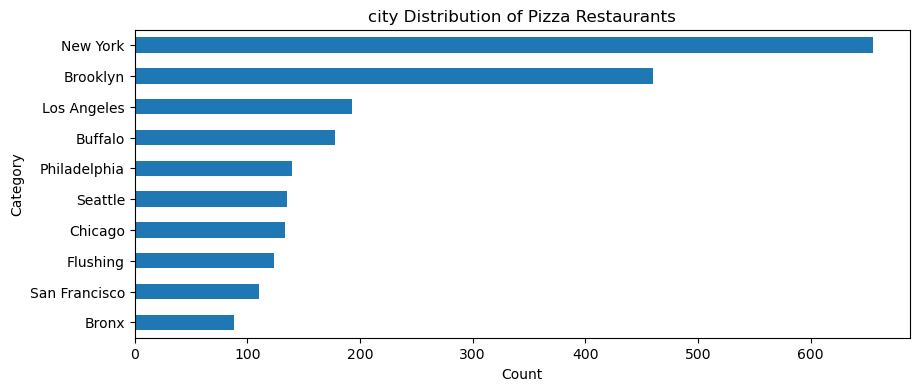

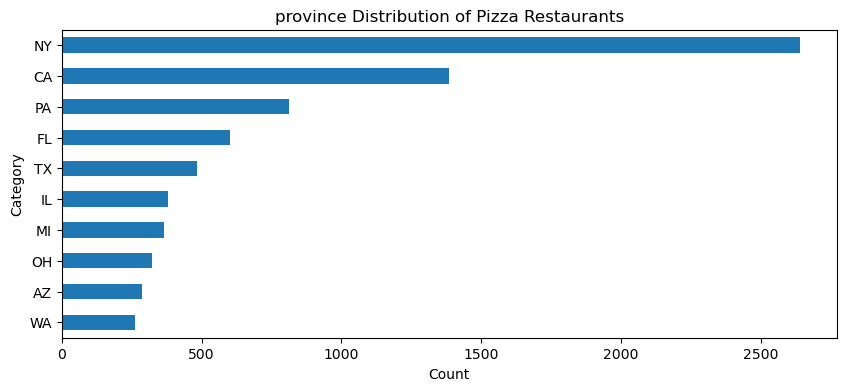

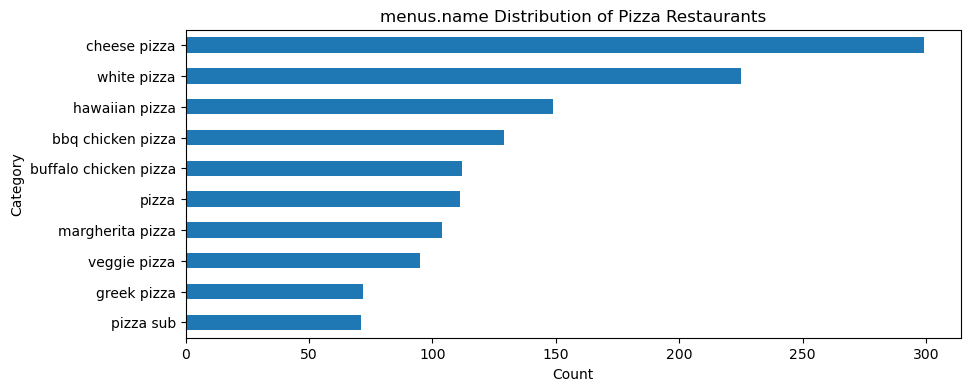

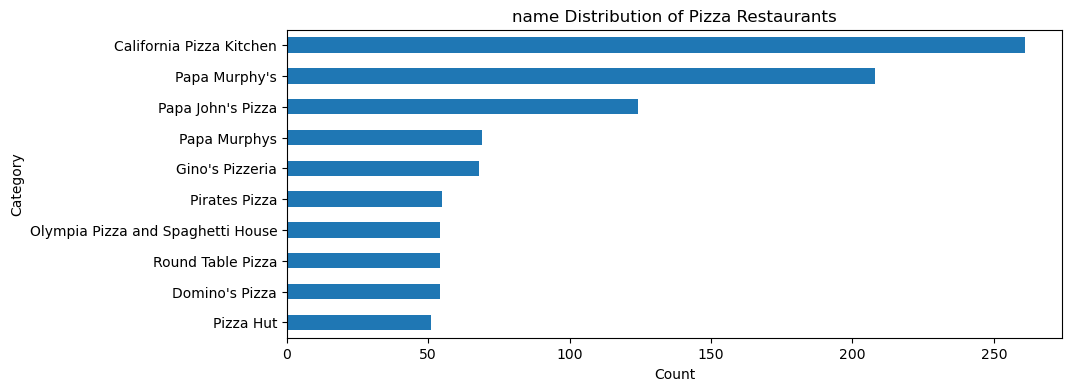

In [29]:
def plot_top_cat(s: pd.Series, outdir: str, tag: str, title: str, n=25):
    vc = top_counts(s, n=n)
    if vc.empty:
        return
    plt.figure(figsize=(10, max(4, 0.35*len(vc))))
    vc.iloc[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Category")

def plot_price_dist(df, run_out, data2_cleaned):
    plot_item_prices(df, run_out, data2_cleaned)
    for col, title in [
        ("city", "Top Cities"),
        ("province", "Top Provinces/States"),
        ("menus.name", "Top Menu Items"),
        ("name", "Top Restaurant Names"),
        ("categories", "Top Raw Categories"),
    ]:
        if col in df.columns:
            plot_top_cat(df[col], run_out, data2_cleaned, title, n=25)

col_list = ["city", "province", "menus.name", "name", "categories"]

for col in col_list:
    if col in data2_cleaned.columns:
        plot_top_cat(data2_cleaned[col], outdir=".", tag=col,
        title=f"{col} Distribution of Pizza Restaurants", n=10)

plt.show()

New York had the most pizza restaurants. Cheese pizza was the most common menu item. California Pizza Kitchen is the most common pizza restaurant chain.

In [30]:
# Drop variable with one unique value, high-cardinality variables, and variables that have been transformed into other features
data2_cleaned = data2_cleaned.drop(columns=['country','menus.currency', 'priceRangeCurrency', 'postalCode', 'menus.name', 'name'])

In [31]:
data2_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dateAdded          9999 non-null   object 
 1   dateUpdated        9999 non-null   object 
 2   primaryCategories  9999 non-null   object 
 3   city               9999 non-null   object 
 4   latitude           9999 non-null   float64
 5   longitude          9999 non-null   float64
 6   menus.dateSeen     9999 non-null   object 
 7   province           9999 non-null   object 
 8   has_description    9999 non-null   int64  
 9   pizza_type         9999 non-null   object 
 10  is_chain           9999 non-null   int64  
 11  menus_amount_avg   9999 non-null   float64
 12  priceRange_avg     9999 non-null   float64
dtypes: float64(4), int64(2), object(7)
memory usage: 1.1+ MB


## Handle Timestamp Variables

In [32]:
# check the formate of the data and time variables
print("dateAdded: \n", data2_cleaned['dateAdded'].head(2))
print("dateUpdated: \n", data2_cleaned['dateUpdated'].head(2))
print("menus.dateSeen: \n", data2_cleaned['menus.dateSeen'].head(2))


dateAdded: 
 0    2017-06-30T05:05:40Z
1    2016-04-02T04:02:49Z
Name: dateAdded, dtype: object
dateUpdated: 
 0    2019-05-01T15:43:09Z
1    2019-05-01T15:27:50Z
Name: dateUpdated, dtype: object
menus.dateSeen: 
 0    2018-05-01T04:25:37.197Z,2018-04-16T04:36:02.3...
1    2018-03-03T02:38:06.381Z,2018-01-18T20:18:10.0...
Name: menus.dateSeen, dtype: object


dataAdded and dataUpdated can easily be converted to a datetime format.

Menus.dateSeen has many comma-separated values from multiple updates. Tricky to convert to a datetime format.
- Dropping this variable will still capture price recommendations, but will lose seasonality trends in pricing.
- Keeping this variable will show seasonality trends in pricing, but will make modeling more difficult.
- Variable can be engineered into recency span to capture how long the menu has been tracked.

In [33]:
# Change data formate of date columns to datetime data type
data2_cleaned['dateAdded'] = pd.to_datetime(data2_cleaned['dateAdded'], errors='coerce', utc=True)
data2_cleaned['dateUpdated'] = pd.to_datetime(data2_cleaned['dateUpdated'], errors='coerce', utc=True)

In [34]:
# Extract year, month, day, and day of week from dateAdded
# data2_cleaned['dateAdded_year'] = data2_cleaned['dateAdded'].dt.year
# year infromation is captured in days_since_added feature
data2_cleaned['dateAdded_month'] = data2_cleaned['dateAdded'].dt.month
# data2_cleaned['dateAdded_day'] = data2_cleaned['dateAdded'].dt.day
# day infroamtion is captured in dateAdded_dayofweek feature
data2_cleaned['dateAdded_dayofweek'] = data2_cleaned['dateAdded'].dt.dayofweek
# Elapsed time since dateAdded
data2_cleaned['days_since_added'] = (pd.Timestamp.now(tz='UTC') - data2_cleaned['dateAdded']).dt.days

#  Extract year, month, day, and day of week from dateUpdated
# data2_cleaned['dateUpdated_year'] = data2_cleaned['dateUpdated'].dt.year
# year infromation is captured in days_since_updated feature
data2_cleaned['dateUpdated_month'] = data2_cleaned['dateUpdated'].dt.month
# data2_cleaned['dateUpdated_day'] = data2_cleaned['dateUpdated'].dt.day
# day infroamtion is captured in dateUpdated_dayofweek feature
data2_cleaned['dateUpdated_dayofweek'] = data2_cleaned['dateUpdated'].dt.dayofweek
# Elapsed time since dateUpdated
data2_cleaned['days_since_updated'] = (pd.Timestamp.now(tz='UTC') - data2_cleaned['dateUpdated']).dt.days

In [35]:
# Compute recency span of menus.dateSeen
def date_span(s):
    if pd.isna(s):
        return 0
    dates = [parser.parse(d) for d in str(s).split(',')]
    return (max(dates) - min(dates)).days if len(dates) > 1 else 0

data2_cleaned['menus_dates_span'] = data2_cleaned['menus.dateSeen'].apply(date_span)


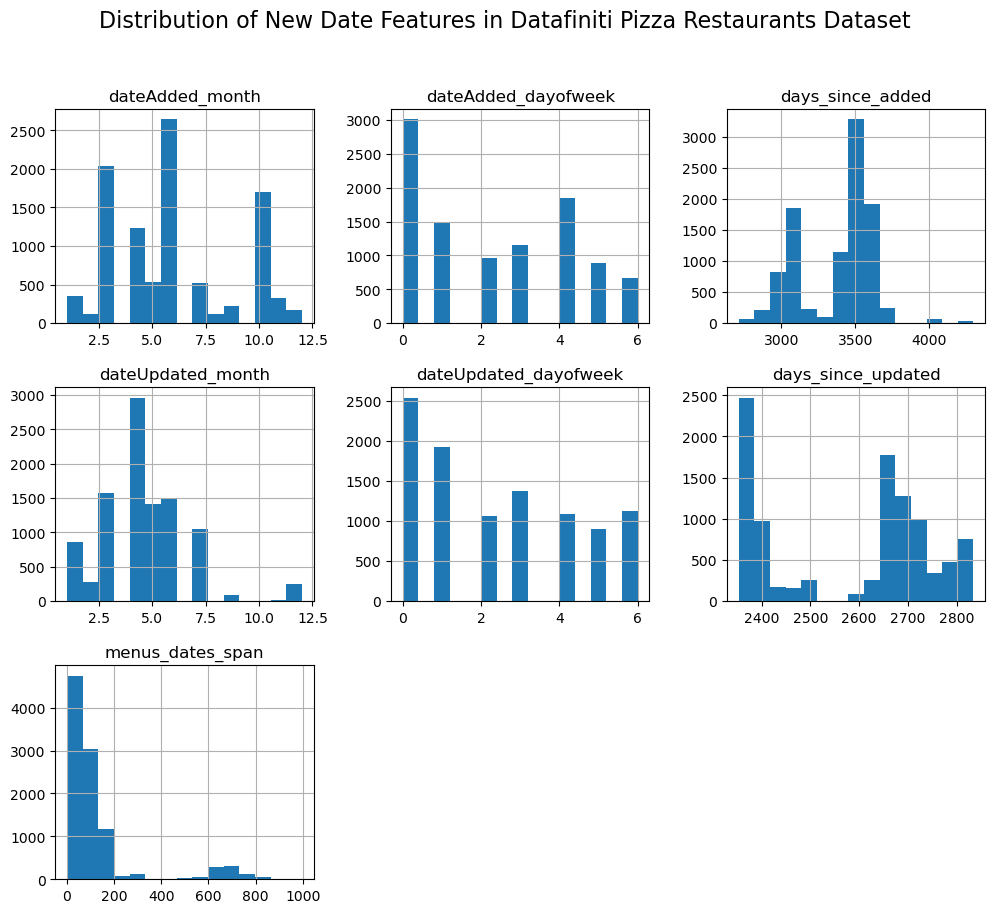

In [36]:
# visulize the distribution of the new date features
new_date_features = ['dateAdded_month', 'dateAdded_dayofweek',
                     'days_since_added', 'dateUpdated_month',
                     'dateUpdated_dayofweek', 'days_since_updated', 'menus_dates_span']
data2_cleaned[new_date_features].hist(figsize=(12,10), bins=15)
plt.suptitle("Distribution of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()

Month and days fo the week variable are categorical variables with numeric values. Can be one-hot encoded for linear modeling.

All other timestamp variables are continuous variables.

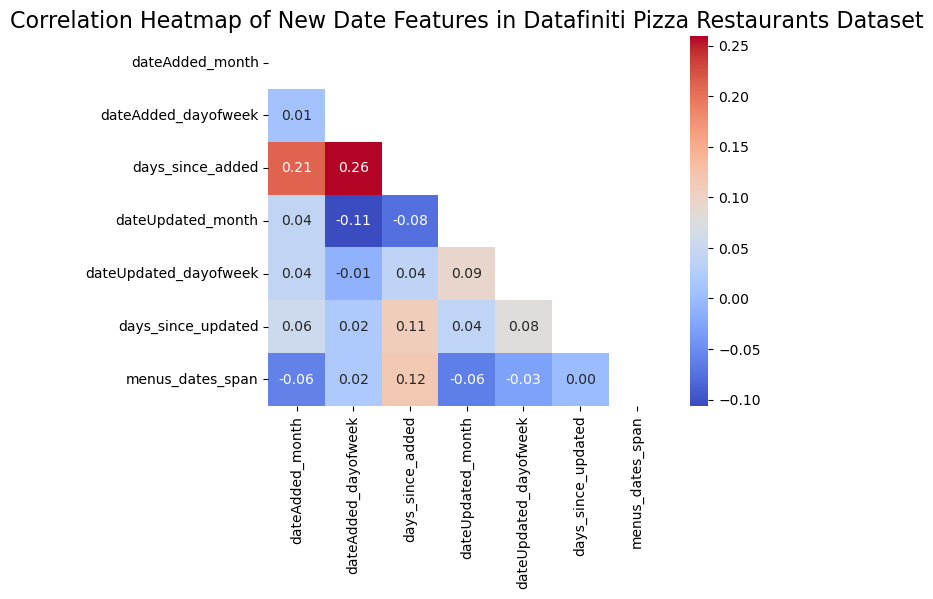

In [37]:
# Check the correlation of the new date features
plt.figuresize=(10,8)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[new_date_features].corr()))
sns.heatmap(data2_cleaned[new_date_features].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title("Correlation Heatmap of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()

All timestap variables are showing low to moderate correlation with eachother.

In [38]:
# Drop original date columns
data2_cleaned = data2_cleaned.drop(columns=['dateAdded', 'dateUpdated', 'menus.dateSeen'])

In [39]:
# Check data types
data2_cleaned.dtypes

primaryCategories         object
city                      object
latitude                 float64
longitude                float64
province                  object
has_description            int64
pizza_type                object
is_chain                   int64
menus_amount_avg         float64
priceRange_avg           float64
dateAdded_month            int32
dateAdded_dayofweek        int32
days_since_added           int64
dateUpdated_month          int32
dateUpdated_dayofweek      int32
days_since_updated         int64
menus_dates_span           int64
dtype: object

In [40]:
# All numeric features in Dataset 2
all_numeric_features = data2_cleaned.select_dtypes(include=['float64','int64', 'int32']).columns

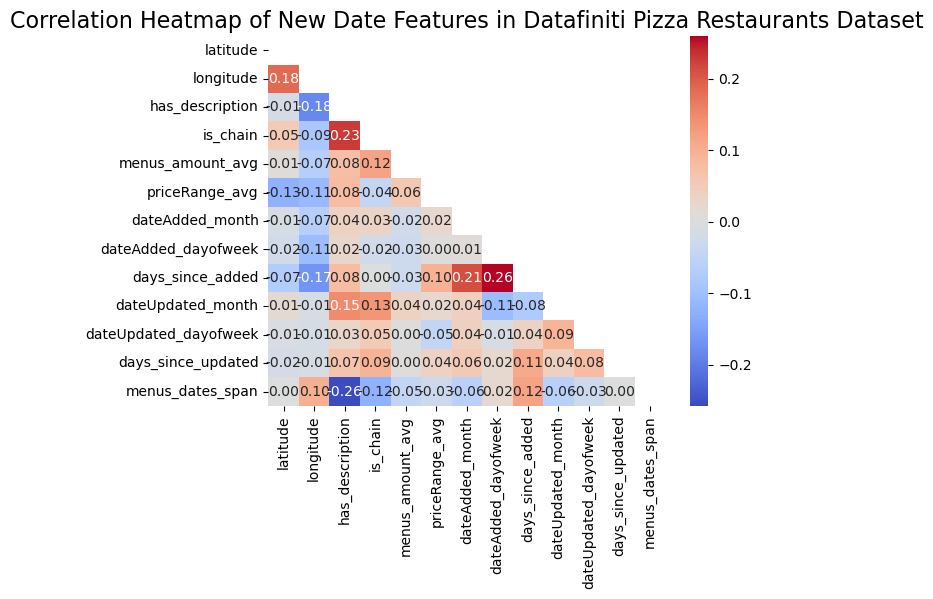

In [41]:
# Check correlation heatmap of all numeric features to ensure no other high correlations exist
plt.figuresize=(12,10)
# creating mask to display only one triangle of the heatmap
mask = np.triu(np.ones_like(data2_cleaned[all_numeric_features].corr()))
sns.heatmap(data2_cleaned[all_numeric_features].corr(), annot=True, fmt=".2f", cmap='coolwarm', mask=mask)
plt.title("Correlation Heatmap of New Date Features in Datafiniti Pizza Restaurants Dataset", fontsize=16)
plt.show()

Most numeric features exhibit low correlation with one another.

Additionally, there is a low correlation with the dependent variables' priceRangeAverage and menus_amount_avg.

Linear relationships are weak, tree-based models may perform better.

## Longitude and Latitude and city

- keep as continuous variables for tree-based models
- could compute distance from reference point (e.g., city center) or group into regions for linear models

- city: city-level location; could blow up the model with too many features. To capture city-level location, keep the top N cities and group the rest into "Other"

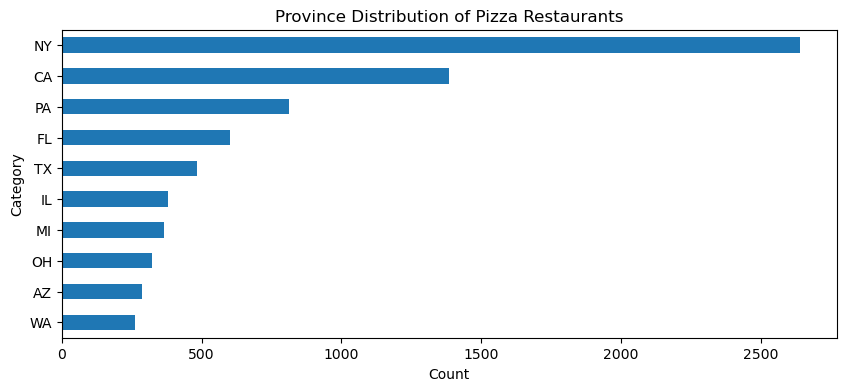

In [42]:
def plot_top_cat(s: pd.Series, outdir: str, tag: str, title: str, n=25):
    vc = top_counts(s, n=n)
    if vc.empty:
        return
    plt.figure(figsize=(10, max(4, 0.35*len(vc))))
    vc.iloc[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Category")
    return plt.show()

plot_top_cat(
    data2_cleaned['province'],
    outdir=".",
    tag="province",
    title="Province Distribution of Pizza Restaurants",
    n=10
)

New York had the most pizza restaurants.

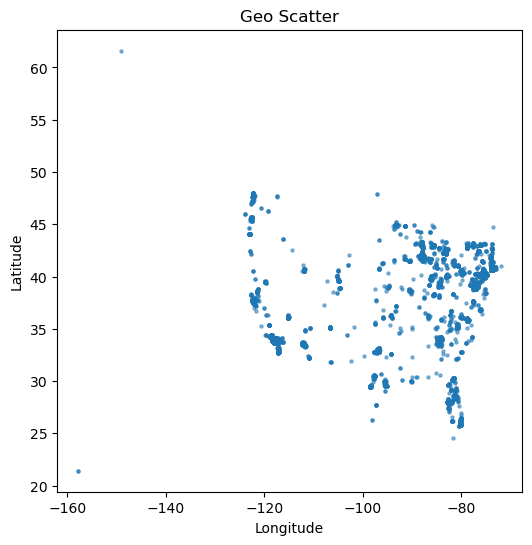

In [43]:
def plot_geo(df: pd.DataFrame, outdir: str, tag: str, sample=5000):
    need = {"latitude", "longitude"}
    if not need.issubset(df.columns):
        return
    pts = df[["latitude", "longitude"]].dropna()
    if len(pts) == 0:
        return
    if len(pts) > sample:
        pts = pts.sample(sample, random_state=42)
    plt.figure(figsize=(6,6))
    plt.scatter(pts["longitude"], pts["latitude"], s=5, alpha=0.5)
    plt.title("Geo Scatter")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")

plot_geo(data2_cleaned, outdir=".", tag="data2_cleaned")
plt.show()

The density of pizza restaurants across the nation is highest in the northeast United States and California.

In [44]:
# Group into regions based on longitude and latitude
# Define function to categorize into regions
def categorize_region(lat, lon):
    if lat >= 40.0:
        return 'North'
    elif lat <= 30.0:
        return 'South'
    elif lon <= -120.0:
        return 'West'
    elif lon >= -80.0:
        return 'East'
    else:
        return 'Central'

data2_cleaned['region'] = data2_cleaned.apply(lambda row: categorize_region(row['latitude'], row['longitude']), axis=1)
# Keep region and drop original longitude and latitude for tree-based models

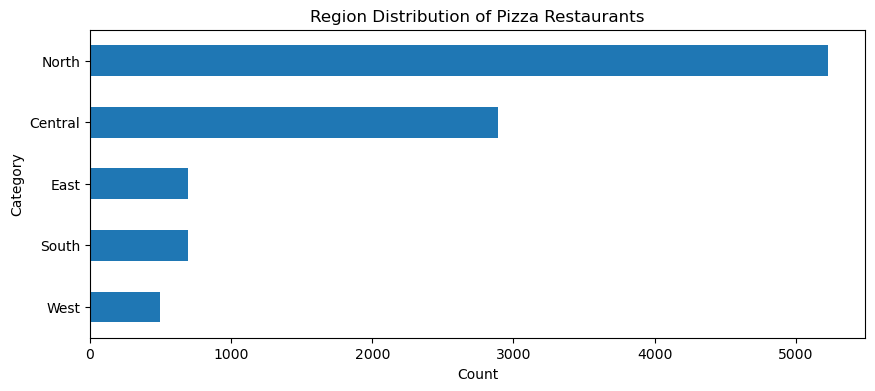

In [45]:
def plot_top_cat(s: pd.Series, outdir: str, tag: str, title: str, n=25):
    vc = top_counts(s, n=n)
    if vc.empty:
        return
    plt.figure(figsize=(10, max(4, 0.35*len(vc))))
    vc.iloc[::-1].plot(kind="barh")
    plt.title(title)
    plt.xlabel("Count")
    plt.ylabel("Category")
    return plt.show()

plot_top_cat(
    data2_cleaned['region'],
    outdir=".",
    tag="region",
    title="Region Distribution of Pizza Restaurants",
    n=10
)

Highest distribution of pizza restaurants in the North region of the US.

### Grouped Variable

In [46]:
# Create a grouped city variable
top_cities = data2_cleaned['city'].value_counts().nlargest(10).index
data2_cleaned['city_grouped'] = data2_cleaned['city'].apply(lambda x: x if x in top_cities else 'Other')
# Drop original city column
data2_cleaned = data2_cleaned.drop(columns=['city'])

In [47]:
# Group rare classes in priceRange_avg to avoid value error when splitting data into train and test sets with stratify=y
# Check the distribution of priceRange_avg
print(data2_cleaned['priceRange_avg'].value_counts())

priceRange_avg
12.5    7979
32.5    1801
13.5      54
13.0      31
11.5      28
47.5      21
10.5      18
15.0      16
5.0       16
52.5       9
17.5       8
16.5       5
10.0       4
14.0       4
3.5        2
18.0       1
14.5       1
25.0       1
Name: count, dtype: int64


In [48]:
# Group rare classes into 'Other'
rare_classes = data2_cleaned['priceRange_avg'].value_counts()[data2_cleaned['priceRange_avg'].value_counts() < 10].index
data2_cleaned['priceRange_avg'] = data2_cleaned['priceRange_avg'].apply(lambda x: 'Other' if x in rare_classes else x)

# Check the distribution again
print(data2_cleaned['priceRange_avg'].value_counts())

priceRange_avg
12.5     7979
32.5     1801
13.5       54
Other      35
13.0       31
11.5       28
47.5       21
10.5       18
15.0       16
5.0        16
Name: count, dtype: int64


10 main classes with average price ranges greater than 10 samples. Much more stable for classification.

## Data Wrangling and Pre-Processing

In [49]:
# Separate features and target variable
X = data2_cleaned.drop(columns=['menus_amount_avg', 'priceRange_avg']) # Features
# Regression target variable
y_reg = data2_cleaned['menus_amount_avg'].astype(float) # Target variable: recomended exact menue price
# Classification target variable
y_clf = data2_cleaned['priceRange_avg'].astype(str) # Target variable: recomended price range average

priceRange_avg produced the value error " The least populated class in y has only one member, which is too few. The minimum number of groups for any class cannot be less than 2." When splitting the data into train and test sets with stratify=y. This error may be because priceRange_avg has a band with one sample.

menus_amount_avg is a continuous variable suitable for regression modeling. The goal is to recommend exact menu pricing based on other features.

priceRange_avg is an ordinal variable suitable for classification modeling. The goal is to recommend price range categories based on other features (ie, budget, mid-range, premium).

- Option to use priceRange_avg: group rare classes or bin into fewer categories to avoid value error when splitting data into train and test sets.

        **menus_amount_avg:** regression task (continuous target).

        **priceRange_avg:** classification task (discrete bins).

### Data Splitting

In [50]:
# Split the data into training and validation sets
# Classification target
train_X, temp_X, train_y_clf, temp_y_clf = train_test_split(X, y_clf, test_size=0.4, random_state=1, stratify=y_clf)

# Split validation data into validation and test sets
valid_X, test_X, valid_y_clf, test_y_clf = train_test_split(temp_X, temp_y_clf, test_size=0.5, random_state=1, stratify=temp_y_clf)

# Check the shape of the predictors in the datasets
print(train_X.shape, valid_X.shape, test_X.shape)

(5999, 16) (2000, 16) (2000, 16)


In [51]:
# Regression target using same indices as classification target
train_y_reg = y_reg.loc[train_y_clf.index]
valid_y_reg = y_reg.loc[valid_y_clf.index]
test_y_reg = y_reg.loc[test_y_clf.index]

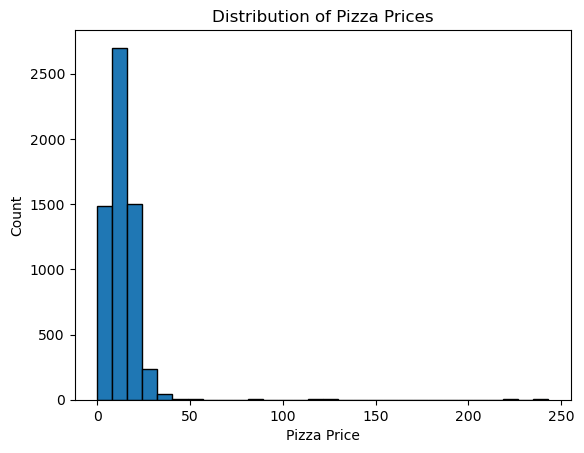

In [52]:
# Check if log transformation is needed for regression target
plt.hist(train_y_reg, bins=30, edgecolor='k')
plt.xlabel("Pizza Price")
plt.ylabel("Count")
plt.title("Distribution of Pizza Prices")
plt.show()

The regression trarget variable is right skewed with outliers. Log transformation may help normalize the distribution and improve model performance.

In [53]:
train_y_log = np.log1p(train_y_reg)   # log(1+y)
valid_y_log = np.log1p(valid_y_reg)
test_y_log  = np.log1p(test_y_reg )

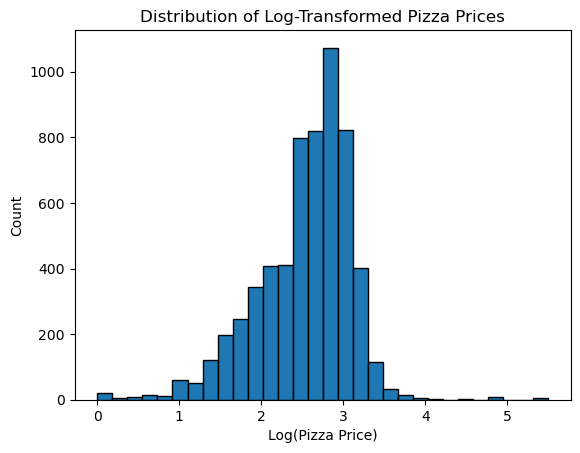

In [54]:
# Histogram after log-transformation
plt.hist(np.log1p(train_y_reg), bins=30, edgecolor='k')
plt.xlabel("Log(Pizza Price)")
plt.ylabel("Count")
plt.title("Distribution of Log-Transformed Pizza Prices")
plt.show()

Data is now normally distributed after log transformation.

In [55]:
data2_cleaned.dtypes

primaryCategories         object
latitude                 float64
longitude                float64
province                  object
has_description            int64
pizza_type                object
is_chain                   int64
menus_amount_avg         float64
priceRange_avg            object
dateAdded_month            int32
dateAdded_dayofweek        int32
days_since_added           int64
dateUpdated_month          int32
dateUpdated_dayofweek      int32
days_since_updated         int64
menus_dates_span           int64
region                    object
city_grouped              object
dtype: object

In [56]:
# Features for different models
linear_features = [
    'primaryCategories', 'region', 'has_description', 'pizza_type',
    'dateAdded_month', 'dateAdded_dayofweek', 'days_since_added',
    'dateUpdated_month', 'dateUpdated_dayofweek', 'days_since_updated',
    'menus_dates_span'
]

tree_features = [
    'primaryCategories', 'latitude', 'longitude', 'province',
    'has_description', 'pizza_type',
    'dateAdded_month', 'dateAdded_dayofweek', 'days_since_added',
    'dateUpdated_month', 'dateUpdated_dayofweek', 'days_since_updated',
    'menus_dates_span', 'city_grouped', 'is_chain'
]

knn_features = [
    'primaryCategories', 'latitude', 'longitude', 'region',
    'pizza_type', 'days_since_added', 'days_since_updated',
    'menus_dates_span'
]

svm_features = [
    'primaryCategories', 'region', 'has_description', 'pizza_type',
    'dateAdded_month', 'dateAdded_dayofweek', 'days_since_added',
    'days_since_updated', 'menus_dates_span'
]

nn_features = [
    'primaryCategories', 'latitude', 'longitude', 'province',
    'has_description', 'pizza_type',
    'dateAdded_month', 'dateAdded_dayofweek', 'days_since_added',
    'dateUpdated_month', 'dateUpdated_dayofweek', 'days_since_updated',
    'menus_dates_span', 'city_grouped', 'is_chain'
]

In [57]:
# Create variables for modelign pipeline
# Linear
train_X_linear = train_X[linear_features].copy()
valid_X_linear = valid_X[linear_features].copy()
test_X_linear  = test_X[linear_features].copy()

# Tree
train_X_tree = train_X[tree_features].copy()
valid_X_tree = valid_X[tree_features].copy()
test_X_tree  = test_X[tree_features].copy()

# KNN
train_X_knn = train_X[knn_features].copy()
valid_X_knn = valid_X[knn_features].copy()
test_X_knn = test_X[knn_features].copy()

# SVM
train_X_svm = train_X[svm_features].copy()
valid_X_svm = valid_X[svm_features].copy()
test_X_svm  = test_X[svm_features].copy()

# NN
train_X_nn = train_X[nn_features].copy()
valid_X_nn = valid_X[nn_features].copy()
test_X_nn  = test_X[nn_features].copy()

## Modeling Strategy

Use Regression to predict the actual price of a pizza menu item.

Use Classification to predict the price tier of a pizza menu item.

Optimize the menu prices to determin cases of underpriced and overpriced menu items.

**Preprocessing for model pipelines:**

In [58]:
# define numeric and categorical features for preprocessing steps in model pipeline
# Linear model preprocessing
lin_num = ['days_since_added', 'days_since_updated', 'menus_dates_span', 'has_description']
lin_cat = ['primaryCategories', 'region', 'dateAdded_month', 'dateUpdated_month','dateAdded_dayofweek', 'dateUpdated_dayofweek', 'pizza_type']

# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
linear_pre = ColumnTransformer([
    ('num', StandardScaler(), lin_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), lin_cat)
], remainder='drop')

In [59]:
# define numeric and categorical features for preprocessing steps in model pipeline
# Tree model preprocessing
tree_num = ['latitude', 'longitude', 'days_since_added', 'days_since_updated', 'menus_dates_span', 'has_description', 'is_chain']
tree_cat = ['primaryCategories', 'province', 'city_grouped', 'dateAdded_month', 'dateUpdated_month','dateAdded_dayofweek', 'dateUpdated_dayofweek', 'pizza_type']

# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
tree_pre = ColumnTransformer([
    ('num', 'passthrough', tree_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), tree_cat)
], remainder='drop')

In [60]:
# define numeric and categorical features for preprocessing steps in model pipeline
# KNN model preprocessing
# KNN models require feature scaling for numeric features
knn_num = ['latitude', 'longitude', 'days_since_added', 'days_since_updated', 'menus_dates_span']
knn_cat = ['primaryCategories', 'region', 'pizza_type']

# preprocessing for KNN, SVM, and NN models
knn_pre = ColumnTransformer([
    ('num', StandardScaler(), knn_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), knn_cat)
], remainder='drop')

In [61]:
# define numeric and categorical features for preprocessing steps in model pipeline
# SVM model preprocessing
# SVM models require feature scaling for numeric features
svm_num = ['days_since_added', 'days_since_updated', 'menus_dates_span', 'has_description']
svm_cat = ['primaryCategories', 'region', 'dateAdded_month', 'dateAdded_dayofweek', 'pizza_type']
# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
svm_pre = ColumnTransformer([
    ('num', StandardScaler(), svm_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), svm_cat)
], remainder='drop')

In [62]:
# define numeric and categorical features for preprocessing steps in model pipeline
# NN model preprocessing
# NN models require feature scaling for numeric features
nn_num = ['latitude', 'longitude', 'days_since_added', 'days_since_updated', 'menus_dates_span', 'has_description', 'is_chain']
nn_cat = ['primaryCategories', 'province', 'city_grouped', 'dateAdded_month', 'dateUpdated_month','dateAdded_dayofweek', 'dateUpdated_dayofweek', 'pizza_type']
# Preprocessing for categorical data: OneHotEncoder (handle unknown categories in test set)
nn_pre = ColumnTransformer([
    ('num', StandardScaler(), nn_num),
    ('cat', OneHotEncoder(handle_unknown='ignore'), nn_cat)
], remainder='drop')

Data is preprocessed and ready to be used in model pipelines.

## Validating and Testing Linear Model Pipeline

### Regression Model (Predicting the actual price)

Target variable: menus_amount_avg

#### Linear Regression Model

In [63]:
# linear modeling pipeline
# usign orginal regression target variable
linear_model = Pipeline(steps=[
    ('preprocessor', linear_pre),
    ('classifier', LinearRegression())
])
linear_model.fit(train_X_linear, train_y_reg);

In [64]:
# Make predictions on validation set
y_pred_lm = linear_model.predict(valid_X_linear)

# Create a DataFrame to hold actual vs predicted values
results_all_pred = pd.DataFrame({'Actual': valid_y_reg})
results_all_pred['Linear Regression'] = y_pred_lm

results_all_pred.head(10)

,Actual,Linear Regression
3083,10.99,14.904172
8254,9.99,11.992931
840,8.29,11.483021
1531,13.99,12.236692
5559,12.95,14.137117
4234,3.75,14.902862
2419,20.49,13.289745
7006,17.99,12.206550
5477,3.50,12.399552
2468,21.00,15.125739


For mid-range pizza prices, the model performs reasonably well in making predictions. For example, at a cost of about $10-15, the model has an error of about $1-3.

For pizzas costing about $3-5, the model overpredicts the price by about $12-15.

For expensive pizzas that cost approximately $18-21, the model underpredicts the price by about $12-15.

The model is showing bias towards the mean price of pizzas.

In [65]:
# Linear Regression model using log-transformed target variable
linear_model_log = Pipeline(steps=[
    ('preprocessor', linear_pre),
    ('classifier', LinearRegression())
])
linear_model_log.fit(train_X_linear, train_y_log);

# Make predictions on validation set
y_pred_lm_log = linear_model_log.predict(valid_X_linear)
# Inverse transform the predictions back to original scale
y_pred_lm_log_inv = np.expm1(y_pred_lm_log)  # exp(y) - 1
# Add to results DataFrame
results_all_pred['Linear Regression (Log Target)'] = y_pred_lm_log_inv
results_all_pred.head(10)

,Actual,Linear Regression,Linear Regression (Log Target)
3083,10.99,14.904172,12.345634
8254,9.99,11.992931,10.304895
840,8.29,11.483021,10.023149
1531,13.99,12.236692,10.011398
5559,12.95,14.137117,11.607022
4234,3.75,14.902862,12.858298
2419,20.49,13.289745,11.285529
7006,17.99,12.206550,10.465227
5477,3.50,12.399552,11.123600
2468,21.00,15.125739,10.953959


The predictor variable was log-transformed to normalize the distribution and then inverted to make predictions on the original scale.

An improvement is observed in model predictions after applying a log transformation to the target variable.

Predictions are compressed towards the middle at about $10-$12. Although underestimation and overestimation of expensive and cheap pizzas are still seen, the proportion of error is smaller. For example, predicting $11 for a $3 pizza instead of $20 for a $3 pizza. These underestimations and overestimations are expected due to regression to the mean.

Use a log transformation for the regression target variable for the following regression modeling tasks.

#### Random Forest Regressor Model

In [66]:
rf_model = Pipeline(steps=[
    ('preprocessor', tree_pre),
    ('rf', RandomForestRegressor(random_state=1, n_estimators=100, max_depth=10, n_jobs=-1))
])
rf_model.fit(train_X_tree, train_y_log);

In [67]:
# Make predictions on validation set
y_pred_rf_log = rf_model.predict(valid_X_tree)
# Inverse transform the predictions back to original scale
y_pred_rf_log_inv = np.expm1(y_pred_rf_log)  # exp(y) - 1
# Add to results DataFrame
results_all_pred['Random Forest (Log Target)'] = y_pred_rf_log_inv
results_all_pred.head(10)

,Actual,Linear Regression,Linear Regression (Log Target),Random Forest (Log Target)
3083,10.99,14.904172,12.345634,9.674096
8254,9.99,11.992931,10.304895,9.500652
840,8.29,11.483021,10.023149,9.575766
1531,13.99,12.236692,10.011398,11.191040
5559,12.95,14.137117,11.607022,9.846380
4234,3.75,14.902862,12.858298,10.650262
2419,20.49,13.289745,11.285529,14.677856
7006,17.99,12.206550,10.465227,10.054784
5477,3.50,12.399552,11.123600,12.209518
2468,21.00,15.125739,10.953959,11.481111


Random Forest models have less error when predicting the prices of both cheap and expensive pizzas compared to the linear regression model.

#### Gradient Boosting Regressor Model

In [68]:
# Create and train Gradient Boosting model
gb_model = Pipeline(steps=[
    ('preprocessor', tree_pre),
    ('gb', GradientBoostingRegressor(random_state=1, n_estimators=100, learning_rate=0.1, max_depth=5, subsample=1.0))
])

gb_model.fit(train_X_tree, train_y_log);

# Make predictions on validation set
y_pred_gb_log = gb_model.predict(valid_X_tree)
# Inverse transform the predictions back to original scale
y_pred_gb_log_inv = np.expm1(y_pred_gb_log)  # exp(y) - 1
# Add to results DataFrame
results_all_pred['Gradient Boosting (Log Target)'] = y_pred_gb_log_inv
results_all_pred.head(10)

,Actual,Linear Regression,Linear Regression (Log Target),Random Forest (Log Target),Gradient Boosting (Log Target)
3083,10.99,14.904172,12.345634,9.674096,10.417584
8254,9.99,11.992931,10.304895,9.500652,10.055559
840,8.29,11.483021,10.023149,9.575766,9.287923
1531,13.99,12.236692,10.011398,11.191040,10.792793
5559,12.95,14.137117,11.607022,9.846380,9.684702
4234,3.75,14.902862,12.858298,10.650262,11.066203
2419,20.49,13.289745,11.285529,14.677856,15.311699
7006,17.99,12.206550,10.465227,10.054784,9.506189
5477,3.50,12.399552,11.123600,12.209518,10.561066
2468,21.00,15.125739,10.953959,11.481111,10.706578


#### Neural Network Regressor Model

In [69]:
# Neural Network model
nn_model = Pipeline(steps=[
    ('preprocessor', nn_pre),
    ('classifier', MLPRegressor(random_state=1, hidden_layer_sizes=(100,), max_iter=300, early_stopping=True, shuffle=True))
])
nn_model.fit(train_X_nn, train_y_log);
# Make predictions on validation set
y_pred_nn_log = nn_model.predict(valid_X_nn)
# Inverse transform the predictions back to original scale
y_pred_nn_log_inv = np.expm1(y_pred_nn_log)  # exp(y) - 1
# Add to results DataFrame
results_all_pred['Neural Network (Log Target)'] = y_pred_nn_log_inv
results_all_pred.head(10)

,Actual,Linear Regression,Linear Regression (Log Target),Random Forest (Log Target),Gradient Boosting (Log Target),Neural Network (Log Target)
3083,10.99,14.904172,12.345634,9.674096,10.417584,14.078051
8254,9.99,11.992931,10.304895,9.500652,10.055559,7.704354
840,8.29,11.483021,10.023149,9.575766,9.287923,7.925611
1531,13.99,12.236692,10.011398,11.191040,10.792793,11.604806
5559,12.95,14.137117,11.607022,9.846380,9.684702,11.623177
4234,3.75,14.902862,12.858298,10.650262,11.066203,15.442885
2419,20.49,13.289745,11.285529,14.677856,15.311699,15.397515
7006,17.99,12.206550,10.465227,10.054784,9.506189,5.754770
5477,3.50,12.399552,11.123600,12.209518,10.561066,11.252237
2468,21.00,15.125739,10.953959,11.481111,10.706578,13.700785


### K-Nearest Neighbors Regressor Model

In [70]:
# KNN modeling pipeline
knn_model = Pipeline(steps=[
    ('preprocessor', knn_pre),
    ('classifier', KNeighborsRegressor(n_neighbors=5, n_jobs=-1))
])
knn_model.fit(train_X_knn, train_y_log);
# Make predictions on validation set
y_pred_knn_log = knn_model.predict(valid_X_knn)
# Inverse transform the predictions back to original scale
y_pred_knn_log_inv = np.expm1(y_pred_knn_log)  # exp(y) - 1
# Add to results DataFrame
results_all_pred['KNN (Log Target)'] = y_pred_knn_log_inv
results_all_pred.head(10)

,Actual,Linear Regression,Linear Regression (Log Target),Random Forest (Log Target),Gradient Boosting (Log Target),Neural Network (Log Target),KNN (Log Target)
3083,10.99,14.904172,12.345634,9.674096,10.417584,14.078051,16.701939
8254,9.99,11.992931,10.304895,9.500652,10.055559,7.704354,15.242641
840,8.29,11.483021,10.023149,9.575766,9.287923,7.925611,11.136467
1531,13.99,12.236692,10.011398,11.191040,10.792793,11.604806,12.800594
5559,12.95,14.137117,11.607022,9.846380,9.684702,11.623177,16.088953
4234,3.75,14.902862,12.858298,10.650262,11.066203,15.442885,11.392643
2419,20.49,13.289745,11.285529,14.677856,15.311699,15.397515,19.036152
7006,17.99,12.206550,10.465227,10.054784,9.506189,5.754770,7.433703
5477,3.50,12.399552,11.123600,12.209518,10.561066,11.252237,15.507939
2468,21.00,15.125739,10.953959,11.481111,10.706578,13.700785,12.277555


#### Choose the best model based on performance metrics and business context.

In [71]:
metrics = {}
for col in results_all_pred.columns.drop("Actual"):
    y_true = results_all_pred["Actual"]
    y_pred = results_all_pred[col]
    metrics[col] = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred)
    }

# Display metrics in a DataFrame
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                                     MAE         MSE       RMSE        R²
Linear Regression               5.613296  153.959001  12.408022  0.033352
Linear Regression (Log Target)  5.668394  160.147416  12.654936 -0.005503
Random Forest (Log Target)      4.856321  135.806791  11.653617  0.147323
Gradient Boosting (Log Target)  4.965381  142.981254  11.957477  0.102277
Neural Network (Log Target)     5.070076  151.688634  12.316194  0.047607
KNN (Log Target)                5.379599  158.280542  12.580960  0.006219



The predictor variable was log-transformed to normalize the distribution and then inverted to make predictions on the original scale.

The best-performing models are the Gradient Boosting Regressor and Random Forest Regressor.

The Gradient Boosting Regressor model is performing well, based on RMSE (one of the lowest) and R^2 (one of the highest) metrics.

The Random Forest Regressor is also performing well, based on the RMSE (one of the lowest) and R^2 (one of the highest) metrics.

Linear models are struggling to capture the non-linear relationships in the data. KNN is likely underperforming due to high dimensionality and the curse of dimensionality. Neural Networks show a slight improvement over linear models, but still underperform compared to Gradient Boosting and Random Forest.

The next step is to tune the hyperparameters for the top two models: the Gradient Boosting Regressor and the Random Forest Regressor.

#### Hyperparameter Tuning for Gradient Boosting Regressor

In [72]:
# Choose your splitter
cv = KFold(n_splits=5, shuffle=True, random_state=1)

# Wrap to auto log/expm1 the TARGET
gb_log = TransformedTargetRegressor(
    regressor=gb_model,
    func=np.log1p,
    inverse_func=np.expm1
)

# Define the parameter grid
param_grid = {
    'gb__n_estimators': [200, 400, 800],
    'gb__learning_rate': [0.02, 0.05, 0.1],
    'gb__max_depth': [2, 3, 4],
    'gb__subsample': [0.7,0.8, 1.0] 
}

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Optimize for MSE
    cv=cv,  # 3-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=0
)

# Fit the grid search to the training data
grid_search.fit(train_X_tree, train_y_reg); # fit on RAW dollares, not log-transformed
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params, best_score

({'gb__learning_rate': 0.02,
  'gb__max_depth': 4,
  'gb__n_estimators': 800,
  'gb__subsample': 0.8},
 -76.75812359465502)

#### Hyperparameter Tuning for Random Forest Regressor

In [73]:
# Search space (good starting ranges)
param_dist = {
    "regressor__rf__n_estimators":      [300, 500, 800, 1000],
    "regressor__rf__max_depth":         [None, 10, 15, 20, 30],
    "regressor__rf__min_samples_split": [2, 5, 10],
    "regressor__rf__min_samples_leaf":  [1, 2, 5, 10],
    "regressor__rf__max_features":      ["sqrt", 0.3, 0.5, 1.0],
    "regressor__rf__bootstrap":         [True],  # False can lead to overfitting
}

# Wrap with log-target
rf_log = TransformedTargetRegressor(
    regressor=rf_model,
    func=np.log1p,
    inverse_func=np.expm1
)

rf_search = RandomizedSearchCV(
    estimator=rf_log,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',
    cv=cv,
    verbose=0,
    n_jobs=-1,
    random_state=1
)
rf_search.fit(train_X_tree, train_y_reg);  # fit on RAW dollares, not log-transformed 
# Get the best parameters and best score
best_params_rf = rf_search.best_params_
best_score_rf = rf_search.best_score_
best_params_rf, best_score_rf

KeyboardInterrupt: 

In [74]:
best_rf = rf_search.best_estimator_
best_gb = grid_search.best_estimator_

# Make predictions on validation set with the best models
results_all_pred['Random Forest (tuned, log)'] = best_rf.predict(valid_X_tree)
results_all_pred['Gradient Boosting (tuned, log)'] = best_gb.predict(valid_X_tree)
results_all_pred.head(10)

,Actual,Linear Regression,Linear Regression (Log Target),Random Forest (Log Target),Gradient Boosting (Log Target),Neural Network (Log Target),KNN (Log Target),"Random Forest (tuned, log)","Gradient Boosting (tuned, log)"
3083,10.99,14.906411,12.347104,9.656488,10.132639,14.024507,14.051658,8.486937,11.679774
8254,9.99,11.988097,10.302469,9.553810,9.998771,7.747464,15.242641,8.730064,12.850498
840,8.29,11.483534,10.023381,9.534380,9.103884,7.878739,11.136467,14.436571,11.151200
1531,13.99,12.238075,10.011170,11.214973,11.461685,11.741385,12.800594,11.572507,13.659719
5559,12.95,14.136594,11.606832,9.837650,8.958886,11.751398,15.988126,7.750508,11.163374
4234,3.75,14.902972,12.858408,10.784143,12.935786,15.483842,11.392643,7.497841,17.469929
2419,20.49,13.290464,11.286052,14.645788,14.542934,15.415465,19.036152,19.631598,15.911712
7006,17.99,12.206999,10.464821,10.049403,9.336066,5.767252,7.433703,8.368268,9.465519
5477,3.50,12.398551,11.122846,12.212634,11.415837,11.227587,15.507939,18.983578,13.476111
2468,21.00,15.126967,10.954470,11.642340,11.382577,13.606900,12.277555,10.582226,12.268328


In [75]:
metrics = {}
for col in results_all_pred.columns.drop("Actual"):
    y_true = results_all_pred["Actual"]
    y_pred = results_all_pred[col]
    metrics[col] = {
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_true, y_pred)),
        "R²": r2_score(y_true, y_pred)
    }

# Display metrics in a DataFrame
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)

                                     MAE         MSE       RMSE        R²
Linear Regression               5.613300  153.958827  12.408015  0.033353
Linear Regression (Log Target)  5.668391  160.147713  12.654948 -0.005504
Random Forest (Log Target)      4.840759  132.841257  11.525678  0.165942
Gradient Boosting (Log Target)  4.977618  143.671433  11.986302  0.097944
Neural Network (Log Target)     5.069674  151.766811  12.319367  0.047116
KNN (Log Target)                5.367801  159.091569  12.613151  0.001127
Random Forest (tuned, log)      4.602238  136.450341  11.681196  0.143282
Gradient Boosting (tuned, log)  4.832184  115.894313  10.765422  0.272345


After hyperparameter tuning, the Gradient Boosting Regressor is showing a slight improvement in RMSE and R^2 metrics. Random Forest metrics are similar to before tuning. 

Gradient Boosting Regressor is the best-performing model based on RMSE and R^2 metrics.

### Classification Model (Predicting the price range category)

Target variable: priceRange_avg

#### Logistic Regression Model

In [76]:
linear_model_pipeline = Pipeline(steps=[('preprocessor', linear_pre),
                                        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=1))])

# Train the linear model
linear_model_pipeline.fit(train_X_linear, train_y_clf);

In [77]:
# Evaluate the linear model on the validation set
valid_predictions_linear = linear_model_pipeline.predict(valid_X_linear)
accuracy_linear = accuracy_score(valid_y_clf, valid_predictions_linear)

print(f"Linear Model Accuracy on Validation Set: {accuracy_linear:.4f}")
print("\nClassification Report for Linear Model on Validation Set:")
print(classification_report(valid_y_clf, valid_predictions_linear))

Linear Model Accuracy on Validation Set: 0.5645

Classification Report for Linear Model on Validation Set:
              precision    recall  f1-score   support

        10.5       0.18      0.67      0.29         3
        11.5       0.56      1.00      0.71         5
        12.5       0.88      0.55      0.68      1596
        13.0       0.78      1.00      0.88         7
        13.5       0.73      1.00      0.85        11
        15.0       0.04      0.67      0.08         3
        32.5       0.30      0.57      0.39       361
        47.5       0.03      1.00      0.05         4
         5.0       0.23      1.00      0.38         3
       Other       0.13      0.86      0.23         7

    accuracy                           0.56      2000
   macro avg       0.39      0.83      0.45      2000
weighted avg       0.77      0.56      0.62      2000



#### Decision Tree Classifier Model

In [78]:
# Decision Tree Classifier model
dt_model_pipeline = Pipeline(steps=[('preprocessor', tree_pre),
                                        ('classifier', DecisionTreeClassifier(random_state=1, class_weight='balanced'))])

# Train the Decision Tree model
dt_model_pipeline.fit(train_X_tree, train_y_clf)

# Evaluate the Decision Tree model on the validation set
valid_predictions_dt = dt_model_pipeline.predict(valid_X_tree)
accuracy_dt = accuracy_score(valid_y_clf, valid_predictions_dt)

print(f"Decision Tree Model Accuracy on Validation Set: {accuracy_dt:.4f}")
print("\nClassification Report for Decision Tree Model on Validation Set:")
print(classification_report(valid_y_clf, valid_predictions_dt))

Decision Tree Model Accuracy on Validation Set: 0.9450

Classification Report for Decision Tree Model on Validation Set:
              precision    recall  f1-score   support

        10.5       1.00      0.67      0.80         3
        11.5       0.83      1.00      0.91         5
        12.5       0.97      0.96      0.97      1596
        13.0       1.00      1.00      1.00         7
        13.5       1.00      1.00      1.00        11
        15.0       0.40      0.67      0.50         3
        32.5       0.86      0.87      0.86       361
        47.5       0.80      1.00      0.89         4
         5.0       1.00      1.00      1.00         3
       Other       0.50      0.86      0.63         7

    accuracy                           0.94      2000
   macro avg       0.84      0.90      0.86      2000
weighted avg       0.95      0.94      0.95      2000



#### Random Forest Classifier Model

In [79]:
# Random Forest Classifier Model
rf_clf_model = Pipeline(steps=[('preprocessor', tree_pre),
                               ('classifier', RandomForestClassifier(random_state=1, class_weight='balanced', n_estimators=100, max_depth=10, n_jobs=-1))])

# Train the Random Forest model
rf_clf_model.fit(train_X_tree, train_y_clf)

# Evaluate the Random Forest model on the validation set
valid_predictions_rf_clf = rf_clf_model.predict(valid_X_tree)
accuracy_rf_clf = accuracy_score(valid_y_clf, valid_predictions_rf_clf)

print(f"Random Forest Classifier Model Accuracy on Validation Set: {accuracy_rf_clf:.4f}")
print("\nClassification Report for Random Forest Classifier Model on Validation Set:")
print(classification_report(valid_y_clf, valid_predictions_rf_clf))

Random Forest Classifier Model Accuracy on Validation Set: 0.9405

Classification Report for Random Forest Classifier Model on Validation Set:
              precision    recall  f1-score   support

        10.5       1.00      0.67      0.80         3
        11.5       1.00      1.00      1.00         5
        12.5       0.94      0.98      0.96      1596
        13.0       1.00      1.00      1.00         7
        13.5       1.00      1.00      1.00        11
        15.0       1.00      0.67      0.80         3
        32.5       0.91      0.75      0.82       361
        47.5       1.00      1.00      1.00         4
         5.0       1.00      1.00      1.00         3
       Other       1.00      0.86      0.92         7

    accuracy                           0.94      2000
   macro avg       0.99      0.89      0.93      2000
weighted avg       0.94      0.94      0.94      2000



#### Support Vector Machine (SVM) Model

In [80]:
# Support Vector Machine (SVM) Model
svm_model_pipeline = Pipeline(steps=[('preprocessor', svm_pre),
                                      ('classifier', SVC(random_state=1, class_weight='balanced'))])

# Train the SVM model
svm_model_pipeline.fit(train_X_svm, train_y_clf)

# Evaluate the SVM model on the validation set
valid_predictions_svm = svm_model_pipeline.predict(valid_X_svm)
accuracy_svm = accuracy_score(valid_y_clf, valid_predictions_svm)

print(f"SVM Model Accuracy on Validation Set: {accuracy_svm:.4f}")
print("\nClassification Report for SVM Model on Validation Set:")
print(classification_report(valid_y_clf, valid_predictions_svm))

SVM Model Accuracy on Validation Set: 0.6875

Classification Report for SVM Model on Validation Set:
              precision    recall  f1-score   support

        10.5       0.18      0.67      0.29         3
        11.5       0.62      1.00      0.77         5
        12.5       0.89      0.71      0.79      1596
        13.0       0.88      1.00      0.93         7
        13.5       1.00      1.00      1.00        11
        15.0       0.13      0.67      0.22         3
        32.5       0.37      0.57      0.45       361
        47.5       0.06      0.75      0.12         4
         5.0       0.50      1.00      0.67         3
       Other       0.08      0.86      0.15         7

    accuracy                           0.69      2000
   macro avg       0.47      0.82      0.54      2000
weighted avg       0.79      0.69      0.72      2000



#### Gradient Boosting Classifier Model

In [81]:
# Gradient Boosting Classifier Model
from sklearn.ensemble import GradientBoostingClassifier

gb_clf_model = Pipeline(steps=[('preprocessor', tree_pre),
                               ('gb', GradientBoostingClassifier(random_state=1, n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0))])

# Train the Gradient Boosting model
gb_clf_model.fit(train_X_tree, train_y_clf)

# Evaluate the Gradient Boosting model on the validation set
valid_predictions_gb_clf = gb_clf_model.predict(valid_X_tree)
accuracy_gb_clf = accuracy_score(valid_y_clf, valid_predictions_gb_clf)

print(f"Gradient Boosting Classifier Model Accuracy on Validation Set: {accuracy_gb_clf:.4f}")
print("\nClassification Report for Gradient Boosting Classifier Model on Validation Set:")
print(classification_report(valid_y_clf, valid_predictions_gb_clf))

Gradient Boosting Classifier Model Accuracy on Validation Set: 0.8890

Classification Report for Gradient Boosting Classifier Model on Validation Set:
              precision    recall  f1-score   support

        10.5       1.00      0.33      0.50         3
        11.5       1.00      1.00      1.00         5
        12.5       0.88      0.99      0.94      1596
        13.0       1.00      1.00      1.00         7
        13.5       1.00      1.00      1.00        11
        15.0       0.50      0.67      0.57         3
        32.5       0.94      0.42      0.58       361
        47.5       0.80      1.00      0.89         4
         5.0       1.00      1.00      1.00         3
       Other       0.75      0.86      0.80         7

    accuracy                           0.89      2000
   macro avg       0.89      0.83      0.83      2000
weighted avg       0.90      0.89      0.87      2000



#### Neural Network Classifier Model

In [82]:
# Neural Network Classifier Model
from sklearn.neural_network import MLPClassifier

nn_clf_model = Pipeline(steps=[('preprocessor', nn_pre),
                               ('classifier', MLPClassifier(random_state=1, hidden_layer_sizes=(100,), max_iter=300, shuffle=True))]) # Removed early_stopping=True

# Train the Neural Network model
# Ensure the target variable is of the correct data type (e.g., string or int)
train_y_clf_str = train_y_clf.astype(str)
valid_y_clf_str = valid_y_clf.astype(str)


nn_clf_model.fit(train_X_nn, train_y_clf_str)

# Evaluate the Neural Network model on the validation set
valid_predictions_nn_clf = nn_clf_model.predict(valid_X_nn)
accuracy_nn_clf = accuracy_score(valid_y_clf_str, valid_predictions_nn_clf)

print(f"Neural Network Classifier Model Accuracy on Validation Set: {accuracy_nn_clf:.4f}")
print("\nClassification Report for Neural Network Classifier Model on Validation Set:")
print(classification_report(valid_y_clf_str, valid_predictions_nn_clf))

Neural Network Classifier Model Accuracy on Validation Set: 0.9555

Classification Report for Neural Network Classifier Model on Validation Set:
              precision    recall  f1-score   support

        10.5       1.00      0.67      0.80         3
        11.5       1.00      1.00      1.00         5
        12.5       0.96      0.98      0.97      1596
        13.0       1.00      1.00      1.00         7
        13.5       1.00      1.00      1.00        11
        15.0       1.00      0.67      0.80         3
        32.5       0.92      0.84      0.88       361
        47.5       1.00      0.75      0.86         4
         5.0       1.00      1.00      1.00         3
       Other       1.00      0.86      0.92         7

    accuracy                           0.96      2000
   macro avg       0.99      0.88      0.92      2000
weighted avg       0.95      0.96      0.95      2000



#### Choose the best model based on performance metrics and business context.

In [83]:
# test with test_X_linear
# test_predictions_linear = linear_model_pipeline.predict(test_X_linear)
# test_accuracy_linear = accuracy_score(test_y_clf, test_predictions_linear)

# print(f"Linear Model Accuracy on Test Set: {test_accuracy_linear:.4f}")
# print("\nClassification Report for Linear Model on Test Set:")
# print(classification_report(test_y_clf, test_predictions_linear))

In [84]:
# Dictionary of accuracy scores for each classifier
classification_accuracies = {
    'Logistic Regression': accuracy_linear,
    'Decision Tree': accuracy_dt,
    'Random Forest': accuracy_rf_clf,
    'SVM': accuracy_svm,
    'Gradient Boosting': accuracy_gb_clf,
    'Neural Network': accuracy_nn_clf
}


for model, accuracy in classification_accuracies.items():
    print(f"{model} Accuracy on Validation Set: {accuracy:.4f}")


accuracy_df = pd.DataFrame.from_dict(classification_accuracies, orient='index', columns=['Accuracy'])
print("\nClassification Model Accuracy Comparison:")
print(accuracy_df.sort_values(by='Accuracy', ascending=False))

Logistic Regression Accuracy on Validation Set: 0.5645
Decision Tree Accuracy on Validation Set: 0.9450
Random Forest Accuracy on Validation Set: 0.9405
SVM Accuracy on Validation Set: 0.6875
Gradient Boosting Accuracy on Validation Set: 0.8890
Neural Network Accuracy on Validation Set: 0.9555

Classification Model Accuracy Comparison:
                     Accuracy
Neural Network         0.9555
Decision Tree          0.9450
Random Forest          0.9405
Gradient Boosting      0.8890
SVM                    0.6875
Logistic Regression    0.5645


# Validation and Testing

### Final Evaluation on Test Set

We will now evaluate the best-performing classification model (Neural Network) on the independent test set to get an unbiased estimate of its performance on unseen data.

In [85]:
# Evaluate the best classification model (Neural Network) on the test set
test_predictions_nn_clf = nn_clf_model.predict(test_X_nn)

# Ensure the test target variable is of the correct data type (string)
test_y_clf_str = test_y_clf.astype(str)

test_accuracy_nn_clf = accuracy_score(test_y_clf_str, test_predictions_nn_clf)

print(f"Neural Network Classifier Model Accuracy on Test Set: {test_accuracy_nn_clf:.4f}")
print("\nClassification Report for Neural Network Classifier Model on Test Set:")
print(classification_report(test_y_clf_str, test_predictions_nn_clf))

Neural Network Classifier Model Accuracy on Test Set: 0.9535

Classification Report for Neural Network Classifier Model on Test Set:
              precision    recall  f1-score   support

        10.5       1.00      1.00      1.00         4
        11.5       1.00      1.00      1.00         6
        12.5       0.97      0.97      0.97      1596
        13.0       1.00      1.00      1.00         6
        13.5       1.00      1.00      1.00        11
        15.0       1.00      0.67      0.80         3
        32.5       0.88      0.87      0.87       360
        47.5       1.00      0.75      0.86         4
         5.0       1.00      1.00      1.00         3
       Other       1.00      1.00      1.00         7

    accuracy                           0.95      2000
   macro avg       0.98      0.93      0.95      2000
weighted avg       0.95      0.95      0.95      2000



#### Optimization Layer

Compare predicted prices to actual prices to determine the optimal price point for each pizza type and location.

Identify underpriced and overpriced menu items based on model predictions.

#### Using Regression Model Predictions for Price Optimization

We will use the predictions from the best performing regression model (Random Forest Regressor or Gradient Boosting Regressor based on the validation results) to suggest potential price adjustments for individual menu items.

In [86]:
# Based on the metrics_df, Random Forest (Log Target) had the lowest RMSE and highest R².
# So we will use the predictions from the Random Forest Regressor for optimization.
# The predictions are already available in the results_all_pred DataFrame.

# Add actual prices to the validation predictions DataFrame for comparison
optimization_df = results_all_pred[['Actual', 'Random Forest (Log Target)']].copy()

# Calculate the difference between predicted and actual prices
optimization_df['Price_Difference'] = optimization_df['Random Forest (Log Target)'] - optimization_df['Actual']

# Identify potentially underpriced and overpriced items based on a threshold (chosen 2 as aribtrary threshold)
# A positive difference suggests the item might be underpriced
# A negative difference suggests the item might be overpriced
underpriced_threshold = 2 # Example threshold
overpriced_threshold = -2

optimization_df['Pricing_Recommendation_Regression'] = 'Fairly Priced'
optimization_df.loc[optimization_df['Price_Difference'] > underpriced_threshold, 'Pricing_Recommendation_Regression'] = 'Potentially Underpriced'
optimization_df.loc[optimization_df['Price_Difference'] < overpriced_threshold, 'Pricing_Recommendation_Regression'] = 'Potentially Overpriced'

# Display some examples of recommendations
print("Pricing Recommendations based on Random Forest Regression Model (Examples):")
display(optimization_df.head(10))

Pricing Recommendations based on Random Forest Regression Model (Examples):


,Actual,Random Forest (Log Target),Price_Difference,Pricing_Recommendation_Regression
3083,10.99,9.656488,-1.333512,Fairly Priced
8254,9.99,9.553810,-0.436190,Fairly Priced
840,8.29,9.534380,1.244380,Fairly Priced
1531,13.99,11.214973,-2.775027,Potentially Overpriced
5559,12.95,9.837650,-3.112350,Potentially Overpriced
4234,3.75,10.784143,7.034143,Potentially Underpriced
2419,20.49,14.645788,-5.844212,Potentially Overpriced
7006,17.99,10.049403,-7.940597,Potentially Overpriced
5477,3.50,12.212634,8.712634,Potentially Underpriced
2468,21.00,11.642340,-9.357660,Potentially Overpriced


#### Using Classification Model Predictions for Price Range Optimization

We will use the predictions from the best performing classification model (Neural Network Classifier based on the validation results) to assess if menu items are appropriately priced within their predicted price range category.

In [87]:
# Add actual and predicted price ranges to the optimization DataFrame
optimization_df['Actual_Price_Range'] = valid_y_clf.astype(str)
optimization_df['Predicted_Price_Range'] = valid_predictions_nn_clf.astype(str)

# Identify items where the predicted price range differs from the actual price range
optimization_df['Pricing_Recommendation_Classification'] = 'Within Predicted Range'
optimization_df.loc[optimization_df['Actual_Price_Range'] != optimization_df['Predicted_Price_Range'], 'Pricing_Recommendation_Classification'] = f'Predicted: ' + optimization_df['Predicted_Price_Range']
print("\nPricing Recommendations based on Neural Network Classification Model (Examples):")
display(optimization_df.head(10))


Pricing Recommendations based on Neural Network Classification Model (Examples):


,Actual,Random Forest (Log Target),Price_Difference,Pricing_Recommendation_Regression,Actual_Price_Range,Predicted_Price_Range,Pricing_Recommendation_Classification
3083,10.99,9.656488,-1.333512,Fairly Priced,12.5,12.5,Within Predicted Range
8254,9.99,9.553810,-0.436190,Fairly Priced,32.5,32.5,Within Predicted Range
840,8.29,9.534380,1.244380,Fairly Priced,32.5,32.5,Within Predicted Range
1531,13.99,11.214973,-2.775027,Potentially Overpriced,12.5,12.5,Within Predicted Range
5559,12.95,9.837650,-3.112350,Potentially Overpriced,12.5,12.5,Within Predicted Range
4234,3.75,10.784143,7.034143,Potentially Underpriced,32.5,32.5,Within Predicted Range
2419,20.49,14.645788,-5.844212,Potentially Overpriced,12.5,12.5,Within Predicted Range
7006,17.99,10.049403,-7.940597,Potentially Overpriced,12.5,12.5,Within Predicted Range
5477,3.50,12.212634,8.712634,Potentially Underpriced,12.5,12.5,Within Predicted Range
2468,21.00,11.642340,-9.357660,Potentially Overpriced,12.5,12.5,Within Predicted Range


These examples demonstrate how the model predictions can be used to identify potential pricing opportunities. In the results section, we will summarize these findings and provide more general recommendations.

# Results

Based on our analysis, we have built and evaluated several regression and classification models to understand the factors influencing pizza prices and predict optimal pricing strategies.

For **Regression Modeling** (predicting the exact price of a menu item), the **Random Forest Regressor** and **Gradient Boosting Regressor** models performed best, showing a better ability to predict pizza prices compared to linear models, KNN, and a basic Neural Network. This is based on the metrics_df, in which Random Forest (Log Target) had the lowest RMSE and highest R². The log transformation of the target variable helped improve the performance of the linear model, but tree-based models still captured the non-linear relationships more effectively.

For **Classification Modeling** (predicting the price range category of a menu item), the **Neural Network Classifier**, **Decision Tree Classifier**, and **Random Forest Classifier** achieved high accuracy on the validation and test sets. This indicates that these models are effective at categorizing pizza menu items into appropriate price ranges based on the features.

The **Optimization Layer** leveraged the predictions from these models to provide actionable insights:

*   By comparing the predicted exact prices from the Random Forest Regressor to the actual prices, we identified menu items that are potentially **underpriced** or **overpriced** based on their characteristics and the market context learned by the model. For example, items with a significant positive `Price_Difference` in the `optimization_df` could be candidates for a price increase.
*   By comparing the predicted price range category from the Neural Network Classifier to the actual price range, we can see if a menu item's current pricing aligns with the model's recommended tier. Items where the `Actual_Price_Range` differs from the `Predicted_Price_Range` might warrant a review of their pricing strategy within the context of their competitive landscape.

___

**Recommendations:**

Based on the optimization layer, here are examples of recommendations for pizza restaurants:

*   **Identify Underpriced Items:** Analyze menu items where the Random Forest model predicted a significantly higher price than the actual price (e.g., `Price_Difference` > \$2 in our `optimization_df`). These items, considering their features and location, could potentially command a higher price to maximize revenue without significantly impacting competitiveness. For instance, if a "Cheese Pizza" in a high-median-price province like AK or MT is priced significantly below the model's prediction, raising its price might be beneficial.
*   **Identify Overpriced Items:** Examine menu items where the Random Forest model predicted a significantly lower price than the actual price (e.g., `Price_Difference` < -\$2 in our `optimization_df`). For these items, especially if the classification model also predicts a lower price range, considering a price reduction might improve competitiveness and attract more customers. This could be the case for certain specialty pizzas in regions with lower median prices.
*   **Align with Predicted Price Ranges:** For items where the Neural Network Classifier predicted a different price range than the actual one, investigate the reasons. If a menu item is priced in a "Budget" range but the model predicts it belongs in a "Mid-Range" tier, it might be an opportunity to reposition the item and adjust its price accordingly. Conversely, if an item is in a "Premium" range but predicted to be "Mid-Range," re-evaluating its value proposition and price point is advisable.
*   **Consider Location and Pizza Type:** Use the insights from the exploratory data analysis (like the median price by province and the popularity of pizza types) in conjunction with the model recommendations. For example, an "Other" pizza type in a lower-priced region might need a different pricing strategy than a "Cheese Pizza" in a high-priced region.

These recommendations should be validated with market research and business considerations, but they provide a data-driven starting point for optimizing pricing strategies.

### Specific Pricing Recommendations Examples

Based on the analysis and the optimization layer, here are a few specific examples of pricing recommendations:

In [88]:
# Filter for potentially underpriced items (e.g., Price_Difference > 5)
underpriced_examples = optimization_df[optimization_df['Price_Difference'] > 5].head(3)

# Filter for potentially overpriced items (e.g., Price_Difference < -5)
overpriced_examples = optimization_df[optimization_df['Price_Difference'] < -5].head(3)

# Filter for items where the classification model predicted a different price range
different_range_examples = optimization_df[optimization_df['Pricing_Recommendation_Classification'].str.startswith('Predicted:')].head(3)

print("Examples of Potentially Underpriced Items:")
display(underpriced_examples)

print("\nExamples of Potentially Overpriced Items:")
display(overpriced_examples)

print("\nExamples of Items with Different Predicted Price Ranges:")
display(different_range_examples)

# To provide more context for these examples, let's retrieve some original features
# Merge with the original valid_X_tree to get features like pizza_type, province, etc.
examples_df = pd.concat([underpriced_examples, overpriced_examples, different_range_examples])
examples_with_features = examples_df.merge(valid_X_tree[['pizza_type', 'province', 'city_grouped', 'is_chain']],
                                           left_index=True, right_index=True, how='left')

print("\nSpecific Examples with Features and Recommendations:")
display(examples_with_features)

Examples of Potentially Underpriced Items:


,Actual,Random Forest (Log Target),Price_Difference,Pricing_Recommendation_Regression,Actual_Price_Range,Predicted_Price_Range,Pricing_Recommendation_Classification
4234,3.75,10.784143,7.034143,Potentially Underpriced,32.5,32.5,Within Predicted Range
5477,3.50,12.212634,8.712634,Potentially Underpriced,12.5,12.5,Within Predicted Range
3105,1.60,10.183436,8.583436,Potentially Underpriced,12.5,12.5,Within Predicted Range



Examples of Potentially Overpriced Items:


,Actual,Random Forest (Log Target),Price_Difference,Pricing_Recommendation_Regression,Actual_Price_Range,Predicted_Price_Range,Pricing_Recommendation_Classification
2419,20.49,14.645788,-5.844212,Potentially Overpriced,12.5,12.5,Within Predicted Range
7006,17.99,10.049403,-7.940597,Potentially Overpriced,12.5,12.5,Within Predicted Range
2468,21.00,11.642340,-9.357660,Potentially Overpriced,12.5,12.5,Within Predicted Range



Examples of Items with Different Predicted Price Ranges:


,Actual,Random Forest (Log Target),Price_Difference,Pricing_Recommendation_Regression,Actual_Price_Range,Predicted_Price_Range,Pricing_Recommendation_Classification
8060,10.0,11.676743,1.676743,Fairly Priced,32.5,12.5,Predicted: 12.5
3608,18.7,11.721282,-6.978718,Potentially Overpriced,12.5,32.5,Predicted: 32.5
5132,2.5,9.077146,6.577146,Potentially Underpriced,32.5,12.5,Predicted: 12.5



Specific Examples with Features and Recommendations:


,Actual,Random Forest (Log Target),Price_Difference,Pricing_Recommendation_Regression,Actual_Price_Range,Predicted_Price_Range,Pricing_Recommendation_Classification,pizza_type,province,city_grouped,is_chain
4234,3.75,10.784143,7.034143,Potentially Underpriced,32.5,32.5,Within Predicted Range,other,NY,Brooklyn,0
5477,3.50,12.212634,8.712634,Potentially Underpriced,12.5,12.5,Within Predicted Range,other,NY,Brooklyn,1
3105,1.60,10.183436,8.583436,Potentially Underpriced,12.5,12.5,Within Predicted Range,other,FL,Other,0
2419,20.49,14.645788,-5.844212,Potentially Overpriced,12.5,12.5,Within Predicted Range,other,NY,Other,0
7006,17.99,10.049403,-7.940597,Potentially Overpriced,12.5,12.5,Within Predicted Range,cheese pizza,CA,Other,0
2468,21.00,11.642340,-9.357660,Potentially Overpriced,12.5,12.5,Within Predicted Range,other,NC,Other,1
8060,10.00,11.676743,1.676743,Fairly Priced,32.5,12.5,Predicted: 12.5,other,OH,Other,1
3608,18.70,11.721282,-6.978718,Potentially Overpriced,12.5,32.5,Predicted: 32.5,other,CA,San Francisco,0
5132,2.50,9.077146,6.577146,Potentially Underpriced,32.5,12.5,Predicted: 12.5,other,IA,Other,0


# Discussion and Conclusion

In this project, we successfully analyzed a dataset of U.S. pizza restaurants to identify factors influencing pizza pricing and develop models to predict prices and price ranges.

Our exploratory data analysis revealed key insights into the distribution of pizza restaurants, the variety of menu items, and the differences in pricing across provinces. We also addressed missing values and engineered new features, including handling timestamp data and grouping categorical variables like restaurant names, cities, and regions.

We built and evaluated several regression and classification models. The tree-based models (Random Forest and Gradient Boosting) and the Neural Network Classifier demonstrated strong performance in predicting pizza prices and price ranges, respectively. The optimization layer provided a framework for translating these predictions into actionable pricing recommendations, helping to identify potentially underpriced or overpriced menu items and assess alignment with predicted price tiers.

While the models provide valuable data-driven insights, it's crucial to remember that these recommendations are based on the patterns in the provided dataset. Real-world pricing decisions should also consider other factors such as:

*   **Local competition:** A detailed analysis of competitor pricing in the immediate area.
*   **Cost of ingredients and operations:** The actual cost of producing each menu item.
*   **Target customer base:** The price sensitivity and expectations of the restaurant's specific customers.
*   **Brand positioning:** Whether the restaurant aims to be a budget, mid-range, or premium option.
*   **Promotions and discounts:** The impact of special offers on pricing strategy.

In conclusion, this project provides a robust analytical framework for U.S. pizza restaurants to inform their pricing strategies. By leveraging data and predictive modeling, operators can gain a competitive edge, maximize revenue, and better serve their customer base. Future work could involve incorporating additional data sources (e.g., local demographics, competitor data, customer reviews), exploring more advanced modeling techniques, and developing a more interactive tool for generating personalized pricing recommendations.

In [ ]:
# =====================================================
# Portfolio-level pricing plan from `reco`
# Aggregates UNDER/OVER opportunities by region/type/chain and proposes median deltas.
# Exports curated CSVs for stakeholders.
# =====================================================
import numpy as np, pandas as pd

if 'reco' in globals():
    # Compute deltas
    rec = reco.copy()
    rec["delta_to_P50"] = rec["P50"] - rec["Actual"]
    rec["pct_delta_to_P50"] = rec["delta_to_P50"] / (rec["Actual"] + 1e-9)

    # Grouping keys (choose what's available)
    group_keys = [c for c in ["province","region","city","pizza_type","is_chain","geo_cluster"] if c in rec.columns]
    if not group_keys:
        group_keys = ["flag"]

    agg = (rec
           .groupby(group_keys, dropna=False)
           .agg(
                n_items=("Actual","size"),
                underpriced=("flag", lambda s: (s=="UNDERpriced").sum()),
                overpriced=("flag", lambda s: (s=="OVERpriced").sum()),
                inrange=("flag", lambda s: (s=="In-range").sum()),
                median_actual=("Actual","median"),
                median_P50=("P50","median"),
                median_delta=("delta_to_P50","median"),
                mean_pct_delta=("pct_delta_to_P50","mean")
            )
           .reset_index()
    )

    display(agg.head(30))

    # Stakeholder exports
    out_dir = "/mnt/data"
    top_under = (rec[rec["flag"]=="UNDERpriced"]
                 .sort_values("delta_to_P50", ascending=False)
                 .head(200))
    top_over = (rec[rec["flag"]=="OVERpriced"]
                .sort_values("delta_to_P50")
                .head(200))

    top_under.to_csv(f"{out_dir}/top_underpriced_items.csv", index=False)
    top_over.to_csv(f"{out_dir}/top_overpriced_items.csv", index=False)
    agg.to_csv(f"{out_dir}/pricing_portfolio_rollup.csv", index=False)
    print("[Block 9] Exported:",
          f"{out_dir}/top_underpriced_items.csv,",
          f"{out_dir}/top_overpriced_items.csv,",
          f"{out_dir}/pricing_portfolio_rollup.csv")
else:
    print("[Block 9] 'reco' not found. Please run Blocks 3–4 first.")


In [ ]:
# =====================================================
# Elasticity sensitivity analysis on portfolio
# Runs revenue deltas at multiple elasticities to show robustness of suggested prices.
# =====================================================
import numpy as np, pandas as pd

if 'reco' in globals():
    rec = reco.copy()
    rec = rec.dropna(subset=["Actual","suggested_price"])
    # Assume base volume 100 units per item unless you have a volume feature
    base_vol = 100.0
    elasticities = [-0.6, -1.0, -1.3, -1.7, -2.0]

    def revenue_delta_row(act, sug, e):
        pct = (sug - act) / (act + 1e-9)
        new_vol = base_vol * (1 + e * pct)
        new_rev = sug * max(new_vol, 0)
        base_rev = act * base_vol
        return new_rev - base_rev

    out_rows = []
    for e in elasticities:
        total_delta = rec.apply(lambda r: revenue_delta_row(r["Actual"], r["suggested_price"], e), axis=1).sum()
        out_rows.append({"elasticity": e, "portfolio_revenue_delta": total_delta})

    sens = pd.DataFrame(out_rows)
    display(sens)

    # Optional breakdown by a key (e.g., province or pizza_type) if present
    key = "province" if "province" in rec.columns else ("pizza_type" if "pizza_type" in rec.columns else None)
    if key:
        rows = []
        for e in elasticities:
            grp = (rec.groupby(key)
                    .apply(lambda g: g.apply(lambda r: revenue_delta_row(r["Actual"], r["suggested_price"], e), axis=1).sum())
                    .reset_index(name="rev_delta"))
            grp["elasticity"] = e
            rows.append(grp)
        sens_by_key = pd.concat(rows, ignore_index=True)
        display(sens_by_key.head(20))
else:
    print("[Block 10] 'reco' not found. Please run Blocks 3–4 first.")


In [ ]:
# =====================================================
# Price-band stability & outlier audit
# Highlights items with extreme deviations from P50 to prioritize manual review.
# =====================================================
import numpy as np, pandas as pd

if 'pred_int' in globals():
    audit = pred_int.copy()
    audit["gap_vs_P50"] = audit["Actual"] - audit["P50"]
    audit["abs_gap"] = audit["gap_vs_P50"].abs()
    audit_sorted = audit.sort_values("abs_gap", ascending=False)

    display(audit_sorted.head(25))

    # Export for triage
    path = "/mnt/data/price_band_outliers.csv"
    audit_sorted.to_csv(path, index=False)
    print(f"[Block 11] Exported full outlier audit to: {path}")
else:
    print("[Block 11] 'pred_int' not found. Please run Block 3 first.")


In [ ]:
# =====================================================
# Quick model comparison snapshot
# Compares a few known regressors on the SAME validation fold for MAE/RMSE/R^2.
# =====================================================
import numpy as np, pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def _safe_predict(model, X):
    try:
        pred = model.predict(X)
        # If model trained on log target, attempt to invert
        if (np.nanmedian(pred) < 0.0) or (np.nanmax(pred) < 15):  # heuristic
            pred = np.expm1(pred)
    except Exception:
        pred = None
    return pred

candidates = []
for name in ["gb_model","rf_model","xgb_model","gbr_model","model_reg_best","best_model"]:
    if name in globals():
        candidates.append((name, globals()[name]))

if candidates and 'valid_X_tree' in globals() and 'valid_y_reg' in globals():
    rows = []
    for name, mdl in candidates:
        yhat = _safe_predict(mdl, valid_X_tree)
        if yhat is None or np.any(~np.isfinite(yhat)):
            continue
        mae = mean_absolute_error(valid_y_reg, yhat)
        rmse = mean_squared_error(valid_y_reg, yhat, squared=False)
        r2 = r2_score(valid_y_reg, yhat)
        rows.append({"model": name, "MAE": mae, "RMSE": rmse, "R2": r2})
    if rows:
        comp = pd.DataFrame(rows).sort_values("RMSE")
        display(comp)
    else:
        print("[Block 12] No comparable predictions produced.")
else:
    print("[Block 12] Missing candidate models or validation split.")


In [ ]:
# =====================================================
# Artifact manifest
# Prints all stakeholder CSV exports generated by the new blocks.
# =====================================================
from pathlib import Path

artifacts = [
    "pricing_recommendations.csv",
    "top_underpriced_items.csv",
    "top_overpriced_items.csv",
    "pricing_portfolio_rollup.csv",
    "price_band_outliers.csv"
]
base = Path("/mnt/data")
found = []
for f in artifacts:
    p = base / f
    if p.exists():
        found.append(p.as_posix())
print("[Block 13] Artifacts present:")
for f in found:
    print(" -", f)
if not found:
    print("No artifacts found yet — run Blocks 4, 9, and 11.")
